# <FONT size="10pt"> <center>Projet 6</center></FONT>


### Notebook 1

#### <FONT size="10pt"> <center>Classifiez automatiquement des biens de consommation</center></FONT>


Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce.

La mission sera de réaliser une étude de faisabilité d'un moteur de classification automatique d’articles, en utilisant leur image et leur description sur le jeu de données d'articles disponible dans la première pièce jointe de ce mail.

Pourrais-tu analyser les descriptions textuelles et les images des produits, au travers des étapes suivantes : 

- Un prétraitement des données texte et image 
- Une extraction de features 
- Une réduction en 2 dimensions, afin de projeter les produits sur un graphique 2D, sous la forme de points dont la couleur correspondra à la catégorie réelle 
- Une analyse du graphique afin de conclure, à l’aide des descriptions ou des images, sur la faisabilité de regrouper automatiquement des produits de même catégorie 
- Une réalisation d’une mesure pour confirmer ton analyse visuelle, en calculant la similarité entre les catégories réelles et les catégories issues d’une segmentation en clusters

## IMPORTATION DES LIBRAIRIES ET DES DONNEES

In [268]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

import nltk
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from PIL import Image

pd.set_option('mode.chained_assignment', None) # Pour éviter la survenue de messages d'erreur lors de la création
                                                 # d'un nouveau dataframe à partir d'un existant

from warnings import filterwarnings
filterwarnings('ignore')  # code optionnel

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

#from IPython.display import display, HTML
#display(HTML("<style>.container { width:90% !important; }</style>")) # Largeur écran

### Entreprise "place de marché"

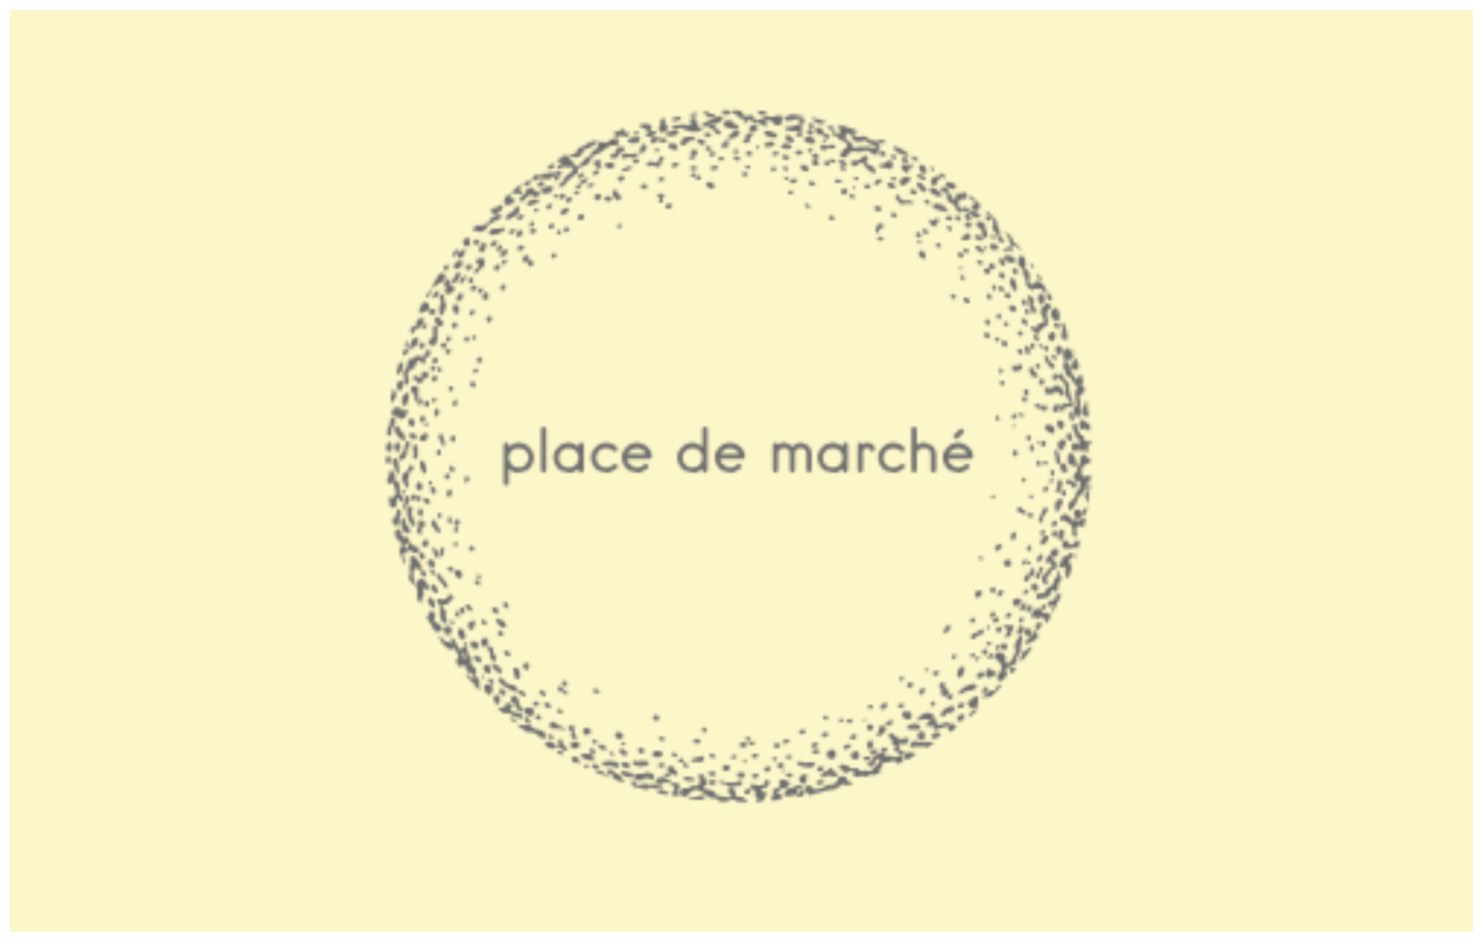

In [269]:
from PIL import Image

# Chemin vers l'image
image_path = 'place_de_marche.png'

# Ouvrir l'image
image = Image.open(image_path)
image = image.convert('RGB')
# Redimensionner l'image (ajuster les dimensions selon vos besoins)
image_resized = image.resize((1900, 1200))

# Ajuster la taille de la figure
plt.figure(figsize=(20, 12))

# Afficher l'image
plt.imshow(image_resized)
plt.axis('off')  # Pour cacher les axes
plt.show()

## Fichier

In [270]:
# Chargement des données
df = pd.read_csv('Flipkart/flipkart_com-ecommerce_sample_1050.csv')

# Affichage du nombre de case
print(f"Nombre total de case est : {len(df)}")

# Affichage des premières lignes du DataFrame
df.head()

Nombre total de case est : 1050


uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                                                                                                       product_url  \
0       http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z   
1                                       http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH   
2                              http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y   
3  http://www.flipkart.com/santosh-royal-fashion-cotton-printed-king-sized-double-bedsheet/p/itmejt9uaqahahuf?pid=BDSEJT9UQWHDUBH4   
4            http://www.flipkart.com/jaipur-print-cotton-floral-king-sized-double-bedsheet/p/itmejthnwahrnt7v?pid=BDSEJTHNGWVGWWQU   

                                                      product_name  \
0       Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                       Sathiyas Cotton Bath Towel   
2                              Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet   
4            Jaipur Print Cotton Floral King sized Double Bedsheet   

                                                                                                                       product_category_tree  \
0                           ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]   
2   ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]   
3    ["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]   
4             ["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]   

                pid  retail_price  discounted_price  \
0  CRNEG7BKMFFYHQ8Z        1899.0             899.0   
1  BTWEGFZHGBXPHZUH         600.0             449.0   
2  BTWEG6SHXTDB2A2Y           NaN               NaN   
3  BDSEJT9UQWHDUBH4        2699.0            1299.0   
4  BDSEJTHNGWVGWWQU        2599.0             698.0   

                                  image  is_FK_Advantage_product  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg                    False   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg                    False   
3  d4684dcdc759dd9cdf41504698d737d8.jpg                    False   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg                    False   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [271]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

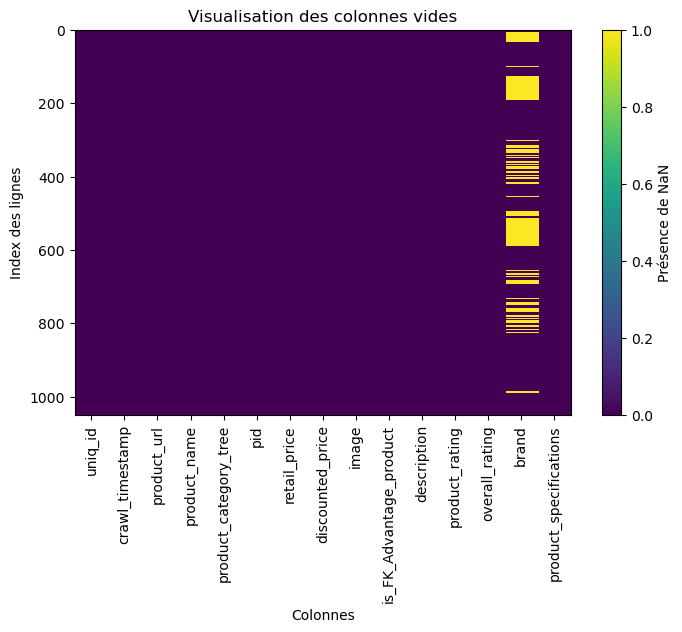

In [272]:
# Visualisation des colonnes vides avec Matplotlib
plt.figure(figsize=(8, 5))
plt.imshow(df.isna(), aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar(label='Présence de NaN')
plt.title('Visualisation des colonnes vides')
plt.xlabel('Colonnes')
plt.ylabel('Index des lignes')
plt.xticks(ticks=np.arange(df.shape[1]), labels=df.columns, rotation=90)
plt.show()

**Nous pouvons observer la colonne marque avec des lignes vides.**

In [273]:
# Doublon
df.duplicated().sum()

0

In [274]:
df.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

In [275]:
# Nombre de valeur unique
df.nunique()

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

- Il y a un `uniq_id`, une `product_url`, un `product_name`, un `pid`, une `description` et une `image` différents pour chaque ligne, ce qui signifie que chaque produit est unique et possède ses propres identifiants, URL, nom, description, et image.

In [276]:
# Calculer le nombre total de valeurs manquantes
total_missing_values = df.isna().sum().sum()

# Calculer le nombre total de valeurs dans le DataFrame
total_values = df.shape[0] * df.shape[1]

# Calculer le pourcentage de valeurs manquantes
percentage_missing_values = (total_missing_values / total_values) * 100

print(percentage_missing_values)

2.165079365079365


### Colonne crawl_timestamp

In [277]:
# Conversion de 'crawl_timestamp' en datetime
df['crawl_timestamp'] = pd.to_datetime(df['crawl_timestamp'])

# Extraction de la date à partir de 'crawl_timestamp'
df['crawl_timestamp'] = df['crawl_timestamp'].dt.date

# Calcul du nombre de dates uniques
nombre_dates_uniques = df['crawl_timestamp'].nunique()

# Suppression de la colonne 'crawl_timestamp'
df.drop(columns=['crawl_timestamp'], inplace=True)

# Affichage du nombre de dates uniques
print(nombre_dates_uniques)

87


**Il y a 87 dates uniques, probablement correspondant aux jours de création, ce qui les rend inutiles.**

### Colonne product_category_tree

In [278]:
# Séparation de la colonne 'product_category_tree' en plusieurs niveaux et création de nouvelles colonnes
niv_columns = ['Category_Level_1', 'Category_Level_2', 'Category_Level_3', 'Category_Level_4', 
               'Category_Level_5', 'Category_Level_6', 'Category_Level_7']

df[niv_columns] = df['product_category_tree'].str.split(' >>', expand=True)

# Suppression de la colonne 'product_category_tree' car maintenat unitile
df.drop(columns=['product_category_tree'], inplace=True)

In [279]:
# Définir une fonction pour supprimer les caractères "[" et "]" et les guillemets
def remove_extra_chars(value):
    if isinstance(value, str):
        return value.replace('[', '').replace(']', '').replace('"', '')
    return value

# Liste des colonnes à nettoyer
category_levels = ['Category_Level_1', 'Category_Level_2', 'Category_Level_3', 'Category_Level_4', 
                   'Category_Level_5', 'Category_Level_6', 'Category_Level_7']

# Appliquer la fonction de nettoyage à chaque colonne
df[category_levels] = df[category_levels].applymap(remove_extra_chars)

In [280]:
df.head()

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   
3  d4684dcdc759dd9cdf41504698d737d8   
4  6325b6870c54cd47be6ebfbffa620ec7   

                                                                                                                       product_url  \
0       http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z   
1                                       http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH   
2                              http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y   
3  http://www.flipkart.com/santosh-royal-fashion-cotton-printed-king-sized-double-bedsheet/p/itmejt9uaqahahuf?pid=BDSEJT9UQWHDUBH4   
4            http://www.flipkart.com/jaipur-print-cotton-floral-king-sized-double-bedsheet/p/itmejthnwahrnt7v?pid=BDSEJTHNGWVGWWQU   

                                                      product_name  \
0       Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                       Sathiyas Cotton Bath Towel   
2                              Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet   
4            Jaipur Print Cotton Floral King sized Double Bedsheet   

                pid  retail_price  discounted_price  \
0  CRNEG7BKMFFYHQ8Z        1899.0             899.0   
1  BTWEGFZHGBXPHZUH         600.0             449.0   
2  BTWEG6SHXTDB2A2Y           NaN               NaN   
3  BDSEJT9UQWHDUBH4        2699.0            1299.0   
4  BDSEJTHNGWVGWWQU        2599.0             698.0   

                                  image  is_FK_Advantage_product  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg                    False   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg                    False   
3  d4684dcdc759dd9cdf41504698d737d8.jpg                    False   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg                    False   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and 

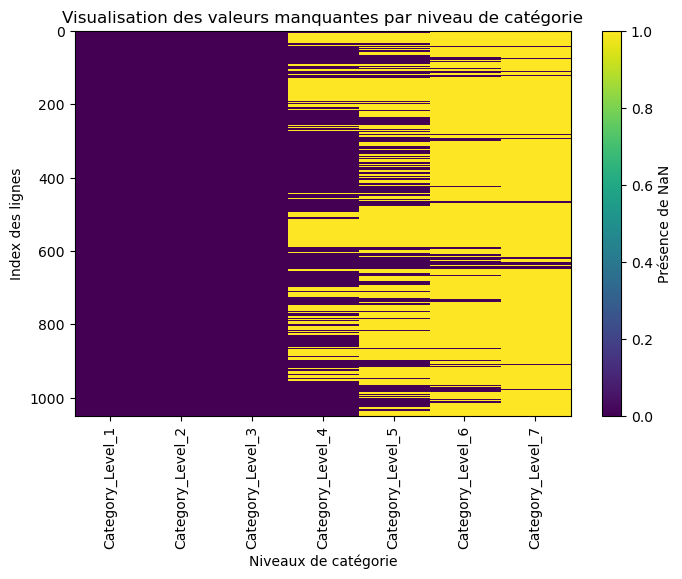

In [281]:
# Liste des colonnes de niveaux de catégories
niveaux_categories = ['Category_Level_1', 'Category_Level_2', 'Category_Level_3', 'Category_Level_4', 
                      'Category_Level_5', 'Category_Level_6', 'Category_Level_7']

# Créer la figure et l'axe
plt.figure(figsize=(8, 5))

# Utiliser imshow pour afficher les valeurs manquantes
plt.imshow(df[niveaux_categories].isna(), aspect='auto', cmap='viridis', interpolation='none')

# Ajouter une barre de couleur
plt.colorbar(label='Présence de NaN')

# Ajouter un titre et des labels
plt.title('Visualisation des valeurs manquantes par niveau de catégorie')
plt.xlabel('Niveaux de catégorie')
plt.ylabel('Index des lignes')

# Ajuster les étiquettes des colonnes
plt.xticks(ticks=np.arange(len(niveaux_categories)), labels=niveaux_categories, rotation=90)

# Afficher le graphique
plt.show()

On constate que **les deux premiers niveaux** sont entièrement remplis. À mesure que l'on progresse vers le niveau 7, les colonnes contiennent de plus en plus de valeurs manquantes.

In [282]:
# Liste des colonnes de niveaux de catégories
niveaux_categories = ['Category_Level_1', 'Category_Level_2', 'Category_Level_3', 'Category_Level_4', 
                      'Category_Level_5', 'Category_Level_6', 'Category_Level_7']

# Boucle à travers chaque niveau de catégorie pour imprimer le nombre de catégories uniques
for i, niveau in enumerate(niveaux_categories, start=1):
    print(f'Nous observons {df[niveau].nunique()} catégories de niveau {i}.')

Nous observons 7 catégories de niveau 1.
Nous observons 62 catégories de niveau 2.
Nous observons 241 catégories de niveau 3.
Nous observons 349 catégories de niveau 4.
Nous observons 297 catégories de niveau 5.
Nous observons 117 catégories de niveau 6.
Nous observons 57 catégories de niveau 7.


**suivre de près les catégories de niveau 3 à 7**

<AxesSubplot:title={'center':'Répartition des catégories'}, ylabel='Category_Level_1'>

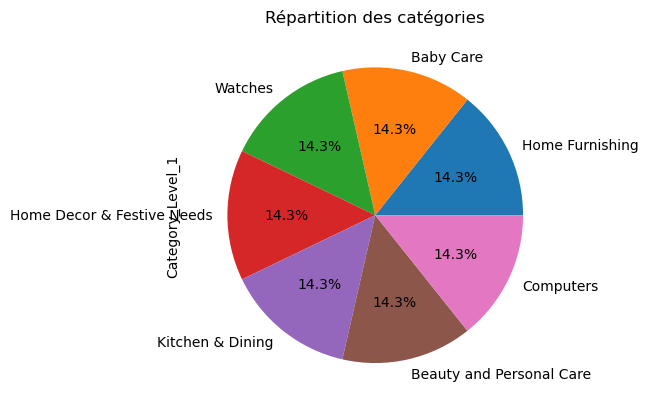

In [283]:
df.Category_Level_1.value_counts().plot(kind='pie',autopct="%1.1f%%", title = "Répartition des catégories")

### Colonne pid

In [284]:
# Affichage des premières valeurs de la colonne 'pid'
premieres_valeurs_pid = df['pid'].head(3)
print(premieres_valeurs_pid)

# Suppression de la colonne 'pid' du DataFrame
df.drop(columns=['pid'], inplace=True)

0    CRNEG7BKMFFYHQ8Z
1    BTWEGFZHGBXPHZUH
2    BTWEG6SHXTDB2A2Y
Name: pid, dtype: object


**Complexe à comprendre**

### Colonne retail_price et discounted_price

In [285]:
# Affichage des premières valeurs des colonnes 'retail_price' et 'discounted_price'
premieres_valeurs_prix = df[['retail_price', 'discounted_price']].head(3)
print(premieres_valeurs_prix)

# Suppression des colonnes 'retail_price' et 'discounted_price' du DataFrame
df.drop(columns=['retail_price', 'discounted_price'], inplace=True)

   retail_price  discounted_price
0        1899.0             899.0
1         600.0             449.0
2           NaN               NaN


**Tarif standard et tarif promotionnel.**

### Colonne image

In [286]:
# Affichage des premières valeurs des colonnes 'image'
premieres_valeurs_image = df[['image']].head(3)
print(premieres_valeurs_image)

                                  image
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg
1  7b72c92c2f6c40268628ec5f14c6d590.jpg
2  64d5d4a258243731dc7bbb1eef49ad74.jpg


**Intéressant pour la séconde partie de notre projet.**

### Colonne is_FK_Advantage_product

In [287]:
# Affichage des premières valeurs des colonnes 'is_FK_Advantage_product' 
premieres_valeurs_is_FK = df[['is_FK_Advantage_product']].head(3)
print(premieres_valeurs_is_FK)

# Suppression des colonnes 'is_FK_Advantage_product'
df.drop(columns=['is_FK_Advantage_product'], inplace=True)

   is_FK_Advantage_product
0                    False
1                    False
2                    False


**complexe à comprendre**

### Colonne description

In [288]:
# Affichage des premières valeurs des colonnes 'description'
premieres_valeurs_description = df[['description']].head(3)
print(premieres_valeurs_description)

**Intéressant pour nos futures analyses.**

### Colonne product_rating et overall_rating (note globale)

In [289]:
# Afficher les comptes des valeurs de 'product_rating'
comptes_product_rating = df['product_rating'].value_counts().head()
print(comptes_product_rating)

# Afficher les comptes des valeurs de 'overall_rating'
comptes_overall_rating = df['overall_rating'].value_counts().head()
print(comptes_overall_rating)

# Filtrer les lignes où 'product_rating' est différent de 'overall_rating'
ratings_differents = df[df['product_rating'] != df['overall_rating']]
#print(ratings_differents)

# Supprimer les colonnes 'product_rating' et 'overall_rating' du DataFrame
df.drop(columns=['product_rating', 'overall_rating'], inplace=True)

ratings_differents

No rating available    889
5                       43
4                       21
3                       12
1                       10
Name: product_rating, dtype: int64
No rating available    889
5                       43
4                       21
3                       12
1                       10
Name: overall_rating, dtype: int64


Empty DataFrame
Columns: [uniq_id, product_url, product_name, image, description, product_rating, overall_rating, brand, product_specifications, Category_Level_1, Category_Level_2, Category_Level_3, Category_Level_4, Category_Level_5, Category_Level_6, Category_Level_7]
Index: []

**Ces deux colonnes semblent similaires et fournissent peu d'informations.**

### Colonne brand (marque)

In [290]:
# Affichage des premières valeurs des colonnes 'brand'
premieres_valeurs_brand = df[['brand']].head(3)
print(premieres_valeurs_brand)

# Affichage des comptes des valeurs de la colonne 'brand', y compris les valeurs manquantes
comptes_marques = df['brand'].value_counts(dropna=False)
print(comptes_marques)

# Suppression de la colonne 'brand' du DataFrame
df.drop(columns=['brand'], inplace=True)

      brand
0  Elegance
1  Sathiyas
2   Eurospa
NaN                   338
Lapguard               11
PRINT SHAPES           11
Lal Haveli             10
Raymond                 8
                     ... 
Rute                    1
NAMS                    1
JewelKraft Designs      1
Budding Bees            1
Mee Mee                 1
Name: brand, Length: 491, dtype: int64


**Colonne intéressante, mais avec beaucoup de valeurs manquantes, elle n'est donc pas utile.**

### Colonne product_specifications

In [291]:
# Afficher la valeur de la deuxième ligne de la colonne 'product_specifications'
specification_deuxieme_ligne = df.loc[1, 'product_specifications']
print(specification_deuxieme_ligne)

{"product_specification"=>[{"key"=>"Machine Washable", "value"=>"Yes"}, {"key"=>"Material", "value"=>"Cotton"}, {"key"=>"Design", "value"=>"Self Design"}, {"key"=>"Brand", "value"=>"Sathiyas"}, {"key"=>"Type", "value"=>"Bath Towel"}, {"key"=>"GSM", "value"=>"500"}, {"key"=>"Model Name", "value"=>"Sathiyas cotton bath towel"}, {"key"=>"Ideal For", "value"=>"Men, Women, Boys, Girls"}, {"key"=>"Model ID", "value"=>"asvtwl322"}, {"key"=>"Color", "value"=>"Red, Yellow, Blue"}, {"key"=>"Size", "value"=>"Mediam"}, {"key"=>"Length", "value"=>"30 inch"}, {"key"=>"Width", "value"=>"60 inch"}, {"key"=>"Number of Contents in Sales Package", "value"=>"3"}, {"key"=>"Sales Package", "value"=>"3 Bath Towel"}]}


**Complexité de compréhension**

In [292]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uniq_id                 1050 non-null   object
 1   product_url             1050 non-null   object
 2   product_name            1050 non-null   object
 3   image                   1050 non-null   object
 4   description             1050 non-null   object
 5   product_specifications  1049 non-null   object
 6   Category_Level_1        1050 non-null   object
 7   Category_Level_2        1050 non-null   object
 8   Category_Level_3        1047 non-null   object
 9   Category_Level_4        679 non-null    object
 10  Category_Level_5        405 non-null    object
 11  Category_Level_6        127 non-null    object
 12  Category_Level_7        57 non-null     object
dtypes: object(13)
memory usage: 106.8+ KB


## Nettoyage des données textuelles

Ce code importe la bibliothèque `nltk` et télécharge les corpus populaires ainsi que les autres ressources nécessaires pour de nombreuses tâches de traitement de texte, tout en supprimant les messages de sortie pendant le téléchargement grâce à l'argument `quiet=True`.

In [293]:
import nltk
nltk.download('popular', quiet=True)

True

In [294]:
# Calcul de la longueur des noms de produits en nombre de mots
longueurs_noms = df['product_name'].apply(lambda x: len(x.split(' ')))

# Affichage de la longueur minimale des noms de produits
longueur_min = longueurs_noms.min()
print(f'La longueur minimum du nom de produit est de {longueur_min}')

# Affichage de la longueur maximale des noms de produits
longueur_max = longueurs_noms.max()
print(f'La longueur maximum du nom de produit est de {longueur_max}')

La longueur minimum du nom de produit est de 2
La longueur maximum du nom de produit est de 27


In [295]:
# Calcul du nombre de mots dans chaque description de produit
longueurs_descriptions = df['description'].apply(lambda x: len(x.split(' ')))

# Affichage de la longueur minimale des descriptions de produits
longueur_min_description = longueurs_descriptions.min()
print(f'La longueur minimum de la description est de {longueur_min_description} mots')

# Affichage de la longueur maximale des descriptions de produits
longueur_max_description = longueurs_descriptions.max()
print(f'La longueur maximum de la description est de {longueur_max_description} mots')

La longueur minimum de la description est de 18 mots
La longueur maximum de la description est de 589 mots


#### Création d'une variable combinant "product_name" et "description"

In [296]:
# Combiner les colonnes 'product_name' et 'description' pour créer la colonne 'DescriptionComplete'
df['DescriptionComplete'] = df['product_name'] + df['description']    # + ' ' +

# Afficher les premières valeurs de la nouvelle colonne 'DescriptionComplete'
premieres_valeurs_description_complete = df['DescriptionComplete'].head(3)
print(premieres_valeurs_description_complete)

0    Elegance Polyester Multicolor Abstract Eyelet Door CurtainKey Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the eleg

In [297]:
# Calcul du nombre de mots dans chaque description complète
longueurs_description_complete = df['DescriptionComplete'].apply(lambda x: len(x.split(' ')))

# Affichage de la longueur minimale des descriptions complètes
longueur_min_description_complete = longueurs_description_complete.min()
print(f'La longueur minimum de la description complète est de {longueur_min_description_complete} mots')

# Affichage de la longueur maximale des descriptions complètes
longueur_max_description_complete = longueurs_description_complete.max()
print(f'La longueur maximum de la description complète est de {longueur_max_description_complete} mots')

La longueur minimum de la description complète est de 21 mots
La longueur maximum de la description complète est de 593 mots


In [298]:
# Calculer la distribution de fréquence des mots dans chaque description complète
frequence_mots_descriptions = df['DescriptionComplete'].apply(lambda x: nltk.FreqDist(x.split(" ")))

# Afficher les distributions de fréquence des mots pour les cinq premières descriptions complètes
frequence_mots_premieres_descriptions = frequence_mots_descriptions.head()
print(frequence_mots_premieres_descriptions)

0    {'Elegance': 4, 'Polyester': 6, 'Multicolor': 5, 'Abstract': 5, 'Eyelet': 5, 'Door': 6, 'CurtainKey': 1, 'Features': 1, 'of': 9, 'Curtain': 4, 'Floral': 1, 'Curtain,Elegance': 1, '(213': 2, 'cm': 3, 'in': 6, 'Height,': 2, 'Pack': 3, '2)': 2, 'Price:': 1, 'Rs.': 1, '899': 1, 'This': 1, 'curtain': 4, 'enhances': 1, 'the': 12, 'look': 1, 'interiors.This': 1, 'is': 3, 'made': 1, 'from': 1, '100%': 1, 'high': 1, 'quality': 1, 'polyester': 1, 'fabric.It': 1, 'features': 1, 'an': 1, 'eyelet': 2, 'style': 1, 'stitch': 1, 'with': 2, 'Metal': 1, 'Ring.It': 1, 'makes': 1, 'room': 2, 'environment': 1, 'romantic': 1, 'and': 6, 'loving.This': 1, 'ant-': 1, 'wrinkle': 1, 'anti': 1, 'shrinkage': 1, 'have': 1, 'elegant': 2, 'apparance.Give': 1, 'your': 2, 'home': 2, 'a': 1, 'bright': 2, 'modernistic': 1, 'appeal': 1, 'these': 1, 'designs.': 1, 'The': 1, 'surreal': 1, 'attention': 1, 'sure': 1, 'to': 4, 'steal': 1, 'hearts.': 1, 'These': 1, 'contemporary': 1, 'valance': 1, 'curtains': 1, 'slide': 1

**La tokenisation** est le processus de décomposition d'un texte en unités plus petites appelées "tokens". Ces unités peuvent être des mots, des phrases ou même des caractères individuels, en fonction de l'objectif de l'analyse. La tokenisation est une étape fondamentale dans le traitement automatique du langage naturel (NLP), car elle permet de préparer le texte brut pour une analyse plus approfondie.

In [299]:
# Définir une fonction pour la tokenisation et la mise en minuscule
def tokenizer(texte):
    texte = texte.lower()  # Convertir en minuscule
    tokens = nltk.word_tokenize(texte)  # Tokeniser le texte
    return tokens

# Appliquer la fonction de tokenisation sur la colonne 'DescriptionComplete'
df['DescriptionCompleteTokenizer'] = df['DescriptionComplete'].apply(tokenizer)

# Afficher les trois premières valeurs de la nouvelle colonne 'DescriptionCompleteTokenizer'
premieres_valeurs_tokenizer = df['DescriptionCompleteTokenizer'].head(3)
print(premieres_valeurs_tokenizer)

0    [elegance, polyester, multicolor, abstract, eyelet, door, curtainkey, features, of, elegance, polyester, multicolor, abstract, eyelet, door, curtain, floral, curtain, ,, elegance, polyester, multicolor, abstract, eyelet, door, curtain, (, 213, cm, in, height, ,, pack, of, 2, ), price, :, rs, ., 899, this, curtain, enhances, the, look, of, the, interiors.this, curtain, is, made, from, 100, %, high, quality, polyester, fabric.it, features, an, eyelet, style, stitch, with, metal, ring.it, makes, the, room, environment, romantic, and, loving.this, curtain, is, ant-, wrinkle, and, anti, shrinkage, and, have, elegant, apparance.give, your, home, a, bright, and, modernistic, appeal, with, these, designs, ., the, surreal, attention, is, ...]
1                                                                                                                                                                                   [sathiyas, cotton, bath, towelspecifications, of, sathiyas, cotton, bat

**Les stop words (ou "mots vides" en français)** sont des mots courants dans une langue qui sont généralement filtrés et supprimés lors du traitement du langage naturel (NLP). Ces mots n'apportent souvent pas de valeur significative pour l'analyse textuelle, car ils apparaissent fréquemment et n'aident pas à distinguer un texte d'un autre.

In [300]:
# Définir une fonction pour supprimer les stop words et les ponctuations
def supprimer_stop_words_et_ponctuations(tokens):
    stop_words = set(nltk.corpus.stopwords.words("english"))
    # Filtrer les tokens pour supprimer les stop words
    tokens_sans_stop_words = [word for word in tokens if word not in stop_words]
    # Filtrer les tokens pour supprimer les mots non alphabétiques (ponctuation, chiffres, etc.)
    tokens_sans_ponctuations = [word for word in tokens_sans_stop_words if word.isalpha()]
    return tokens_sans_ponctuations

# Appliquer la fonction sur la colonne 'DescriptionCompleteTokenizer'
df['DescriptionCompleteTokenizer'] = df['DescriptionCompleteTokenizer'].apply(supprimer_stop_words_et_ponctuations)

# Afficher les trois premières valeurs de la nouvelle colonne 'DescriptionCompleteTokenizer'
premieres_valeurs_tokenizer_sans_stopwords = df['DescriptionCompleteTokenizer'].head(3)
print(premieres_valeurs_tokenizer_sans_stopwords)

0    [elegance, polyester, multicolor, abstract, eyelet, door, curtainkey, features, elegance, polyester, multicolor, abstract, eyelet, door, curtain, floral, curtain, elegance, polyester, multicolor, abstract, eyelet, door, curtain, cm, height, pack, price, rs, curtain, enhances, look, curtain, made, high, quality, polyester, features, eyelet, style, stitch, metal, makes, room, environment, romantic, curtain, wrinkle, anti, shrinkage, elegant, home, bright, modernistic, appeal, designs, surreal, attention, sure, steal, hearts, contemporary, eyelet, valance, curtains, slide, smoothly, draw, apart, first, thing, morning, welcome, bright, sun, rays, want, wish, good, morning, whole, world, draw, close, evening, create, special, moments, joyous, beauty, given, soothing, prints, bring, home, elegant, curtain, softly, filters, light, ...]
1                                                                                                                                                         

In [301]:
# Calcul de la longueur des descriptions complètes après nettoyage
longueurs_descriptions = df['DescriptionCompleteTokenizer'].apply(len)

# Affichage de la longueur minimale des descriptions complètes après nettoyage
longueur_min_description = longueurs_descriptions.min()
print(f'La longueur minimale des descriptions complètes après nettoyage est de {longueur_min_description} mots')

# Affichage de la longueur maximale des descriptions complètes après nettoyage
longueur_max_description = longueurs_descriptions.max()
print(f'La longueur maximale des descriptions complètes après nettoyage est de {longueur_max_description} mots')

# Calcul de la fréquence des mots dans toutes les descriptions complètes
tous_les_mots = df['DescriptionCompleteTokenizer'].sum()
frequence_mots = pd.Series(tous_les_mots).value_counts()

# Affichage de la fréquence minimale des mots dans toutes les descriptions complètes
frequence_min = frequence_mots.min()
print(f'La fréquence minimale d\'apparition des mots dans toutes les descriptions complètes est de {frequence_min}')

# Affichage de la fréquence maximale des mots dans toutes les descriptions complètes
frequence_max = frequence_mots.max()
print(f'La fréquence maximale d\'apparition des mots dans toutes les descriptions complètes est de {frequence_max}')

La longueur minimale des descriptions complètes après nettoyage est de 10 mots
La longueur maximale des descriptions complètes après nettoyage est de 365 mots
La fréquence minimale d'apparition des mots dans toutes les descriptions complètes est de 1
La fréquence maximale d'apparition des mots dans toutes les descriptions complètes est de 632


**Le stemming** est un processus en traitement du langage naturel (NLP) qui consiste à réduire les mots à leur racine ou base commune (appelée "stem"). L'objectif du stemming est de regrouper différentes formes d'un mot pour qu'elles soient traitées de manière identique. Par exemple, les mots "running", "runner", "ran", et "runs" peuvent être réduits à la même racine "run".

In [302]:
from nltk.stem import SnowballStemmer

# Initialiser le stemmer anglais de Snowball
stem_en = SnowballStemmer("english")

# Définir une fonction pour appliquer le stemming sur une liste de tokens
def stemming(tokens):
    return [stem_en.stem(word) for word in tokens]

# Appliquer la fonction de stemming sur la colonne 'DescriptionCompleteTokenizer'
df['DescriptionCompleteTokenizer'] = df['DescriptionCompleteTokenizer'].apply(stemming)

# Afficher les premières valeurs de la colonne 'DescriptionCompleteTokenizer' après stemming
premieres_valeurs_stemming = df['DescriptionCompleteTokenizer'].head()
print(premieres_valeurs_stemming)

0    [eleg, polyest, multicolor, abstract, eyelet, door, curtainkey, featur, eleg, polyest, multicolor, abstract, eyelet, door, curtain, floral, curtain, eleg, polyest, multicolor, abstract, eyelet, door, curtain, cm, height, pack, price, rs, curtain, enhanc, look, curtain, made, high, qualiti, polyest, featur, eyelet, style, stitch, metal, make, room, environ, romant, curtain, wrinkl, anti, shrinkag, eleg, home, bright, modernist, appeal, design, surreal, attent, sure, steal, heart, contemporari, eyelet, valanc, curtain, slide, smooth, draw, apart, first, thing, morn, welcom, bright, sun, ray, want, wish, good, morn, whole, world, draw, close, even, creat, special, moment, joyous, beauti, given, sooth, print, bring, home, eleg, curtain, soft, filter, light, ...]
1                                                                                                                                                                                                                                 

In [303]:
# Calcul de la longueur des descriptions complètes après nettoyage et stemming
longueurs_descriptions_stemmed = df['DescriptionCompleteTokenizer'].apply(len)

# Affichage de la longueur minimale des descriptions complètes après nettoyage et stemming
longueur_min_description_stemmed = longueurs_descriptions_stemmed.min()
print(f'La longueur minimale des descriptions complètes après nettoyage et stemming est de {longueur_min_description_stemmed} mots')

# Affichage de la longueur maximale des descriptions complètes après nettoyage et stemming
longueur_max_description_stemmed = longueurs_descriptions_stemmed.max()
print(f'La longueur maximale des descriptions complètes après nettoyage et stemming est de {longueur_max_description_stemmed} mots')

# Calcul de la fréquence des mots dans toutes les descriptions complètes après stemming
tous_les_mots_stemmed = df['DescriptionCompleteTokenizer'].sum()
frequence_mots_stemmed = pd.Series(tous_les_mots_stemmed).value_counts()

# Affichage de la fréquence minimale des mots dans toutes les descriptions complètes après stemming
frequence_min_stemmed = frequence_mots_stemmed.min()
print(f'La fréquence minimale d\'apparition des mots dans toutes les descriptions complètes après stemming est de {frequence_min_stemmed}')

# Affichage de la fréquence maximale des mots dans toutes les descriptions complètes après stemming
frequence_max_stemmed = frequence_mots_stemmed.max()
print(f'La fréquence maximale d\'apparition des mots dans toutes les descriptions complètes après stemming est de {frequence_max_stemmed}')

La longueur minimale des descriptions complètes après nettoyage et stemming est de 10 mots
La longueur maximale des descriptions complètes après nettoyage et stemming est de 365 mots
La fréquence minimale d'apparition des mots dans toutes les descriptions complètes après stemming est de 1
La fréquence maximale d'apparition des mots dans toutes les descriptions complètes après stemming est de 870


**Le lemmatizer (ou "lemmatisation" en français)** est un processus en traitement du langage naturel (NLP) qui consiste à réduire les mots à leur forme canonique ou de base, appelée "lemme". Par exemple, dans une phrase comme "Les chats mangeaient des poissons", la lemmatisation transformerait "chats" en "chat", "mangeaient" en "manger", et "poissons" en "poisson". Contrairement au stemming, qui coupe simplement les suffixes pour obtenir la racine du mot, la lemmatisation prend en compte le contexte et la signification du mot pour le ramener à sa forme de base.

In [304]:
# Installez manuellement le modèle via spaCy :

import spacy.cli
spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [305]:
import spacy

# Charger le modèle linguistique de spaCy pour l'anglais
nlp = spacy.load('en_core_web_sm')

# Définir une fonction pour appliquer la lemmatisation sur une liste de tokens
def lemmatizer(tokens):
    # Joindre les tokens en une seule chaîne de caractères
    texte = ' '.join(tokens)
    # Traiter le texte avec spaCy pour obtenir des objets Token
    doc = nlp(texte)
    # Extraire les lemmes de chaque token
    lemmes = [token.lemma_ for token in doc]
    return lemmes

# Appliquer la fonction de lemmatisation sur la colonne 'DescriptionCompleteTokenizer'
df['DescriptionCompleteTokenizer'] = df['DescriptionCompleteTokenizer'].apply(lemmatizer)

# Afficher les premières valeurs de la colonne 'DescriptionCompleteTokenizer' après lemmatisation
premieres_valeurs_lemmatizer = df['DescriptionCompleteTokenizer'].head()
print(premieres_valeurs_lemmatizer)  

0    [eleg, polyest, multicolor, abstract, eyelet, door, curtainkey, featur, eleg, polyest, multicolor, abstract, eyelet, door, curtain, floral, curtain, eleg, polyest, multicolor, abstract, eyelet, door, curtain, cm, height, pack, price, rs, curtain, enhanc, look, curtain, make, high, qualiti, poly, featur, eyelet, style, stitch, metal, make, room, environ, romant, curtain, wrinkl, anti, shrinkag, eleg, home, bright, modernist, appeal, design, surreal, attent, sure, steal, heart, contemporari, eyelet, valanc, curtain, slide, smooth, draw, apart, first, thing, morn, welcom, bright, sun, ray, want, wish, good, morn, whole, world, draw, close, even, creat, special, moment, joyous, beauti, give, sooth, print, bring, home, eleg, curtain, soft, filter, light, ...]
1                                                                                                                                                                                                                                     

In [306]:
# Calcul de la longueur des descriptions complètes après nettoyage et lemmatisation
longueurs_descriptions_lemmatized = df['DescriptionCompleteTokenizer'].apply(len)

# Affichage de la longueur minimale des descriptions complètes après nettoyage et lemmatisation
longueur_min_description_lemmatized = longueurs_descriptions_lemmatized.min()
print(f'La longueur minimale des descriptions complètes après nettoyage et lemmatisation est de {longueur_min_description_lemmatized} mots')

# Affichage de la longueur maximale des descriptions complètes après nettoyage et lemmatisation
longueur_max_description_lemmatized = longueurs_descriptions_lemmatized.max()
print(f'La longueur maximale des descriptions complètes après nettoyage et lemmatisation est de {longueur_max_description_lemmatized} mots')

# Calcul de la fréquence des mots dans toutes les descriptions complètes après lemmatisation
tous_les_mots_lemmatized = df['DescriptionCompleteTokenizer'].sum()
frequence_mots_lemmatized = pd.Series(tous_les_mots_lemmatized).value_counts()

# Affichage de la fréquence minimale des mots dans toutes les descriptions complètes après lemmatisation
frequence_min_lemmatized = frequence_mots_lemmatized.min()
print(f'La fréquence minimale d\'apparition des mots dans toutes les descriptions complètes après lemmatisation est de {frequence_min_lemmatized}')

# Affichage de la fréquence maximale des mots dans toutes les descriptions complètes après lemmatisation
frequence_max_lemmatized = frequence_mots_lemmatized.max()
print(f'La fréquence maximale d\'apparition des mots dans toutes les descriptions complètes après lemmatisation est de {frequence_max_lemmatized}')

La longueur minimale des descriptions complètes après nettoyage et lemmatisation est de 10 mots
La longueur maximale des descriptions complètes après nettoyage et lemmatisation est de 365 mots
La fréquence minimale d'apparition des mots dans toutes les descriptions complètes après lemmatisation est de 1
La fréquence maximale d'apparition des mots dans toutes les descriptions complètes après lemmatisation est de 870


In [307]:
# Combiner les mots restants en une seule phrase
#df['DescriptionCompleteTokenizer'] = df['DescriptionCompleteTokenizer'].apply(lambda tokens: ' '.join(map(str, tokens)))

In [308]:
# Combiner les mots restants en une seule phrase

def join_tokens(tokens):
    return ' '.join(str(word) for word in tokens)

df['DescriptionCompleteTokenizer'] = df['DescriptionCompleteTokenizer'].apply(join_tokens)

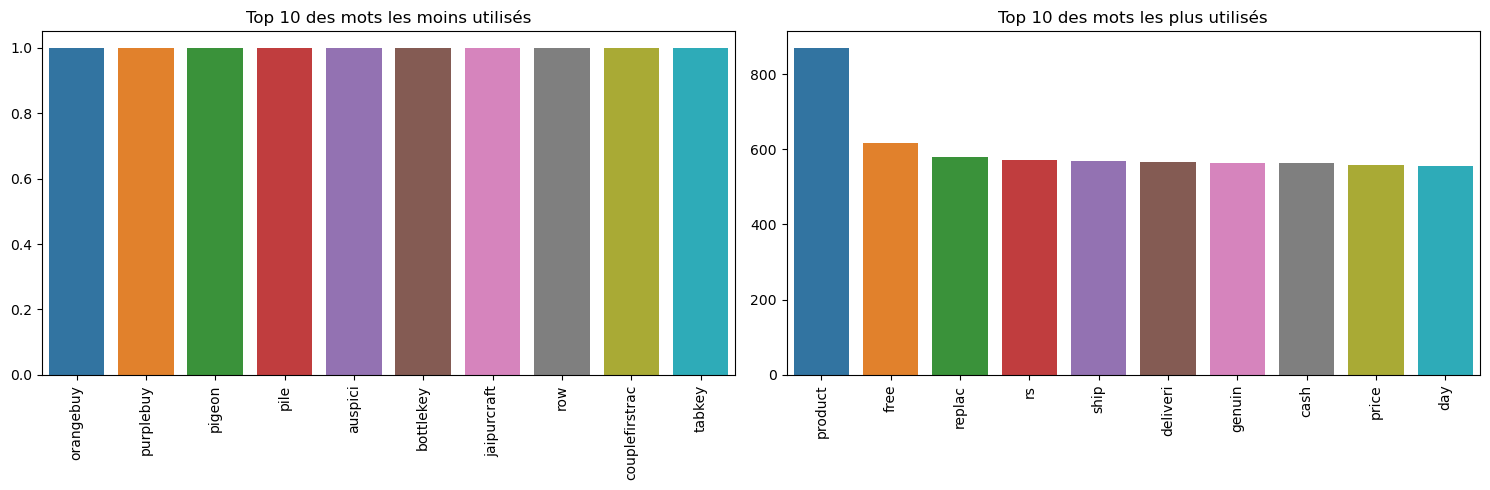

In [309]:
# Combiner les mots restants en une seule chaîne de caractères
all_words = ' '.join(df['DescriptionCompleteTokenizer'])

# Calculer la fréquence des mots
freq_dist = nltk.FreqDist(all_words.split())

# Convertir la fréquence des mots en DataFrame et trier par fréquence décroissante
freq_df = pd.DataFrame.from_dict(freq_dist, orient='index', columns=['Frequency'])
freq_df = freq_df.sort_values(by='Frequency', ascending=False).reset_index()
freq_df.columns = ['Word', 'Frequency']

# Créer des sous-plots pour les graphiques des mots les plus et les moins utilisés
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Graphique des 10 mots les moins utilisés
sns.barplot(x='Word', y='Frequency', data=freq_df.tail(10), ax=axes[0])
axes[0].set_title('Top 10 des mots les moins utilisés')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_xlabel('')
axes[0].set_ylabel('')

# Graphique des 10 mots les plus utilisés
sns.barplot(x='Word', y='Frequency', data=freq_df.head(10), ax=axes[1])
axes[1].set_title('Top 10 des mots les plus utilisés')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xlabel('')
axes[1].set_ylabel('')

# Afficher les graphiques
plt.tight_layout()
plt.show()

## Illustration linguistique

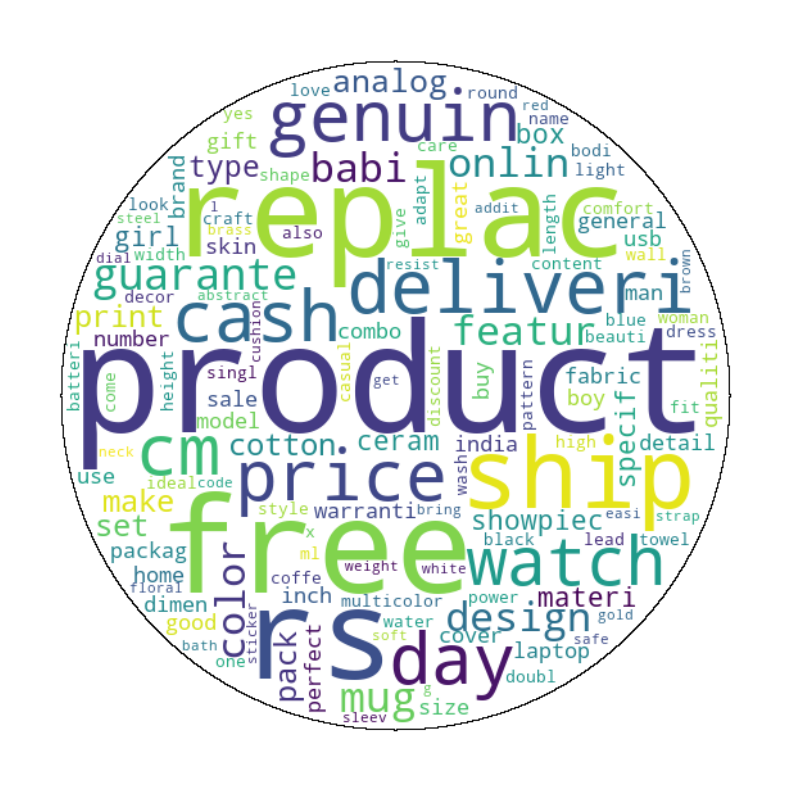

In [310]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud
import nltk
import pandas as pd

# Charger l'image de masque
mask_path = "etendu.png"  # Assurez-vous que le chemin est correct
masque = np.array(Image.open(mask_path))

# Initialiser le générateur de nuage de mots avec le masque
wordcloud = WordCloud(
    width=800, 
    height=800, 
    max_font_size=200, 
    min_font_size=10,
    background_color='white', 
    mask=masque, 
    contour_width=0.1
)

# Combiner les mots de la colonne 'DescriptionCompleteTokenizer' en une seule chaîne
mots_combines = ' '.join(df['DescriptionCompleteTokenizer'])

# Générer la distribution de fréquence des mots
frequence_mots = nltk.FreqDist(mots_combines.split())

# Générer le nuage de mots à partir des fréquences des mots
wordcloud.generate_from_frequencies(frequence_mots)

# Afficher le nuage de mots
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

## Modification de la colonne cible

In [311]:
# Calculer le nombre d'occurrences de chaque valeur dans la colonne 'Category_Level_2'
valeurs_comptes = df['Category_Level_2'].value_counts()

# Trier les valeurs comptées par ordre croissant
valeurs_comptes_tries = valeurs_comptes.sort_values()

# Afficher les valeurs comptées triées
print(valeurs_comptes_tries)

 Beauty Accessories                   1
 Dinnerware & Crockery                1
 Garden & Leisure                     1
 Clocks                               1
 Housekeeping & Laundry               1
 Men's Grooming                       1
 Women's Hygiene                      1
 Pressure Cookers & Pans              1
 Kripa's Home Furnishing              1
 Strollers & Activity Gear            1
 Software                             1
 Candles & Fragrances                 1
 Consumables & Disposables            1
 TRUE Home Decor & Festive Needs      1
 JMD Home Furnishing                  1
 Tidy Home Furnishing                 1
 Laptops                              2
 Computer Components                  2
 Storage                              2
 Eye Care                             2
 Furniture & Furnishings              2
 Tableware & Cutlery                  3
 Living Room Furnishing               3
 Tablet Accessories                   3
 Religion & Devotion                  3


In [312]:
# Copier les valeurs de la colonne 'Category_Level_1' dans une nouvelle colonne 'Category_Level_1_Texte'
df['Category_Level_1_Texte'] = df['Category_Level_1']

# Factoriser la colonne 'Category_Level_1' en assignant des codes numériques à chaque catégorie unique
df['Category_Level_1'], _ = pd.factorize(df['Category_Level_1'])

## Export

In [313]:
df.to_csv("Data_Final_cleaning_projet_6", index=False)

In [314]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   uniq_id                       1050 non-null   object
 1   product_url                   1050 non-null   object
 2   product_name                  1050 non-null   object
 3   image                         1050 non-null   object
 4   description                   1050 non-null   object
 5   product_specifications        1049 non-null   object
 6   Category_Level_1              1050 non-null   int64 
 7   Category_Level_2              1050 non-null   object
 8   Category_Level_3              1047 non-null   object
 9   Category_Level_4              679 non-null    object
 10  Category_Level_5              405 non-null    object
 11  Category_Level_6              127 non-null    object
 12  Category_Level_7              57 non-null     object
 13  DescriptionComplet

## IMPORTATION DES LIBRAIRIES

In [315]:
# Importations de base
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Importations pour le prétraitement et la visualisation du texte
import nltk
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from PIL import Image

# Importations pour le Machine Learning
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import manifold, decomposition, cluster, metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# Importations pour le traitement de texte et l'IA
import gensim
import multiprocessing
from gensim.models import Word2Vec
import tensorflow_hub as hub
import tensorflow as tf
from transformers import AutoModel, BertTokenizerFast, BertModel
import torch  # facilité les calculs intensif

# Téléchargement des jeux de données NLTK populaires
nltk.download('popular', quiet=True)

# Options pandas
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Optionnel : Filtrer les avertissements
from warnings import filterwarnings
filterwarnings('ignore')

# Optionnel : Ajuster la largeur de l'écran pour IPython
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

## FONCTIONS 

In [316]:
def reduce_dimensionality_pca(data, num_components):
    """
    Réduit la dimensionnalité des données en utilisant l'analyse en composantes principales (PCA).

    Paramètres:
    data (DataFrame): Les données à réduire.
    num_components (int): Le nombre de composantes principales à conserver.

    Retourne:
    ndarray: Les données transformées avec les composantes principales.
    """
    # Initialiser PCA avec le nombre de composantes principales
    pca = PCA(n_components=num_components)
    
    # Appliquer PCA sur les données
    reduced_data = pca.fit_transform(data)
    
    return reduced_data



def reduce_dimensionality_tsne(data):
    """
    Réduit la dimensionnalité des données en utilisant t-SNE pour visualiser les clusters en 2D.

    Paramètres:
    data (DataFrame): Les données à réduire.

    Retourne:
    ndarray: Les données transformées avec t-SNE en 2D.
    """
    # Initialiser t-SNE avec les paramètres spécifiés
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
    
    # Appliquer t-SNE sur les données
    tsne_result = tsne.fit_transform(data)
    
    return tsne_result


def plot_tsne_clusters(tsne_data):
    """
    Affiche un graphique 2D des clusters t-SNE réels.

    Paramètres:
    tsne_data (ndarray): Données transformées par t-SNE.

    Retourne:
    None
    """
    # Créer un DataFrame à partir des résultats t-SNE
    tsne_df = pd.DataFrame(tsne_data, columns=['tsne1', 'tsne2'])
    tsne_df['class'] = df['Category_Level_1']
    
    # Créer le graphique
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        x='tsne1', y='tsne2', hue='class', palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
        data=tsne_df, legend='brief'
    )
    
    # Ajouter les titres et les étiquettes
    plt.title('TSNE selon les vraies classes', fontsize=30, pad=35, fontweight='bold')
    plt.xlabel('tsne1', fontsize=26, fontweight='bold')
    plt.ylabel('tsne2', fontsize=26, fontweight='bold')
    plt.legend(prop={'size': 14})
    
    # Afficher le graphique
    plt.show()
    
    
def plot_kmeans_clusters(tsne_data):
    """
    Crée des clusters via KMeans sur les données t-SNE et affiche un graphique des clusters.

    Paramètres:
    tsne_data (ndarray): Données transformées par t-SNE.

    Retourne:
    None
    """
    # Créer un DataFrame à partir des résultats t-SNE
    tsne_df = pd.DataFrame(tsne_data, columns=['tsne1', 'tsne2'])
    tsne_df['class'] = df['Category_Level_1']
    
    # Appliquer KMeans sur les données t-SNE
    kmeans = cluster.KMeans(n_clusters=7, n_init=100)
    kmeans.fit(tsne_data)
    
    # Ajouter les étiquettes des clusters au DataFrame
    tsne_df['cluster'] = kmeans.labels_

    # Créer le graphique
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        x='tsne1', y='tsne2', hue='cluster',
        palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
        data=tsne_df, legend='brief'
    )
    
    # Ajouter les titres et les étiquettes
    plt.title('TSNE selon les clusters', fontsize=30, pad=35, fontweight='bold')
    plt.xlabel('tsne1', fontsize=26, fontweight='bold')
    plt.ylabel('tsne2', fontsize=26, fontweight='bold')
    plt.legend(prop={'size': 14})
    
    # Afficher le graphique
    plt.show()
    
    # Calculer et afficher l'ARI (Adjusted Rand Index)
    ari = round(metrics.adjusted_rand_score(df['Category_Level_1'], kmeans.labels_), 2)
    print("ARI : ", ari)
    

    
def plot_tsne_and_kmeans_clusters(tsne_data):
    """
    Affiche des graphiques 2D des clusters t-SNE réels et KMeans, et crée une matrice de confusion.

    Paramètres:
    tsne_data (ndarray): Données transformées par t-SNE.

    Retourne:
    None
    """

    # Créer un DataFrame à partir des résultats t-SNE
    df_tsne = pd.DataFrame(tsne_data, columns=['tsne1', 'tsne2'])
    df_tsne['class'] = df['Category_Level_1']

    # Définir les catégories pour la légende
    categories = df['Category_Level_1_Texte'].unique()
    category_palette = sns.color_palette('tab10', len(categories))

    # Agrandir la figure
    plt.figure(figsize=(24, 8))

    # Afficher les vraies classes
    plt.subplot(131)
    sns.scatterplot(
        x='tsne1', y='tsne2', hue='class', palette=category_palette, s=50, alpha=0.6,
        data=df_tsne, legend='brief'
    )
    plt.title('TSNE selon les vraies classes', fontsize=20, fontweight='bold')
    plt.xlabel('tsne1', fontsize=18, fontweight='bold')
    plt.ylabel('tsne2', fontsize=18, fontweight='bold')
    plt.legend(title='Categorie', labels=categories, prop={'size': 12})

    # Créer des clusters avec KMeans
    kmeans = cluster.KMeans(n_clusters=7, n_init=100)
    kmeans.fit(tsne_data)
    df_tsne['cluster'] = kmeans.labels_

    # Afficher les clusters KMeans
    plt.subplot(132)
    sns.scatterplot(
        x='tsne1', y='tsne2', hue='cluster',
        palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
        data=df_tsne, legend='brief'
    )
    plt.title('TSNE selon les clusters', fontsize=20, fontweight='bold')
    plt.xlabel('tsne1', fontsize=18, fontweight='bold')
    plt.ylabel('tsne2', fontsize=18, fontweight='bold')
    plt.legend(title='Clusters', prop={'size': 12})

    # Créer la matrice de confusion
    try:
        labels = df['Category_Level_1']
        conf_mat = metrics.confusion_matrix(labels, kmeans.labels_)
        corresp = np.argmax(conf_mat, axis=0)
        labels_df = pd.Series(labels, name="y_true").to_frame()
        labels_df['y_pred'] = kmeans.labels_
        labels_df['y_pred_transform'] = labels_df['y_pred'].apply(lambda x: corresp[x])

        cls_labels_transform = np.array(labels_df['y_pred_transform'])
        labels = df['Category_Level_1']
        conf_mat2 = metrics.confusion_matrix(labels, cls_labels_transform)
        list_labels = df['Category_Level_1_Texte'].unique()

        df_cm = pd.DataFrame(conf_mat2, index=[label for label in list_labels], columns=[i for i in "0123456"])
        plt.subplot(133)
        plt.title('Matrice de confusion', size=20, fontweight='bold')
        sns.heatmap(df_cm.T, annot=True, cmap="Blues", fmt='d')
        plt.xlabel('Groupes KMeans', fontsize=18, fontweight='bold')
        plt.ylabel('Catégories', fontsize=18, fontweight='bold')
        plt.show()

    except:
        labels = df.iloc[:525]['Category_Level_1']
        conf_mat = metrics.confusion_matrix(labels, kmeans.labels_)
        corresp = np.argmax(conf_mat, axis=0)
        labels_df = pd.Series(labels, name="y_true").to_frame()
        labels_df['y_pred'] = kmeans.labels_
        labels_df['y_pred_transform'] = labels_df['y_pred'].apply(lambda x: corresp[x])

        cls_labels_transform = np.array(labels_df['y_pred_transform'])
        labels = df.iloc[:525]['Category_Level_1']
        conf_mat2 = metrics.confusion_matrix(labels, cls_labels_transform)
        list_labels = df['Category_Level_1_Texte'].unique()

        df_cm = pd.DataFrame(conf_mat2, index=[label for label in list_labels], columns=[i for i in "0123456"])
        plt.subplot(133)
        plt.title('Matrice de confusion', size=20, fontweight='bold')
        sns.heatmap(df_cm.T, annot=True, cmap="Blues", fmt='d')
        plt.xlabel('Groupes KMeans', fontsize=18, fontweight='bold')
        plt.ylabel('Catégories', fontsize=18, fontweight='bold')
        plt.show()

    # Afficher l'ARI (Adjusted Rand Index)
    ari = round(metrics.adjusted_rand_score(labels, kmeans.labels_), 3)
    print("L'indice de Rand ajusté (\033[1mARI\033[0m) pour ce modèle d'extraction de caractéristiques est de {}.".format(ari))

# Analyse NLP de la colonne texte

## Approches Bag-of-words 


Une approche **Bag-of-words (BoW)** est une méthode couramment utilisée en traitement du langage naturel (NLP) pour représenter du texte sous une forme numérique compréhensible par les algorithmes d'apprentissage automatique. Dans une approche BoW, un texte (document) est représenté par un vecteur de taille fixe, où chaque dimension du vecteur correspond à un mot du vocabulaire total extrait de l'ensemble des documents.

### CountVectorizer

**CountVectorizer** est une classe de la bibliothèque scikit-learn qui permet de convertir une collection de documents textuels en une matrice de tokens (mots) comptés. Chaque document est représenté par un vecteur de longueur égale au nombre total de mots uniques dans tous les documents. Chaque entrée dans ce vecteur représente le nombre de fois qu'un mot particulier apparaît dans le document.

### Extraction des features

In [317]:
# Créer le vecteur bag of words
vectorizer = CountVectorizer().fit(df['DescriptionCompleteTokenizer']) 

# Transformer le texte en une matrice sparse
bow_sparse_matrix = vectorizer.transform(df['DescriptionCompleteTokenizer'])

bow_sparse_matrix

<1050x4109 sparse matrix of type '<class 'numpy.int64'>'
	with 32606 stored elements in Compressed Sparse Row format>

### Réduction dimensionnelle et analyse graphique des clusters

**Le TruncatedSVD** (Singular Value Decomposition tronquée) est une technique de réduction de dimensionnalité utilisée principalement pour les matrices creuses (sparse matrices). Il est particulièrement utile dans le traitement du langage naturel et l'analyse de texte lorsque les données sont représentées sous forme de grandes matrices creuses, comme celles générées par des techniques de bag-of-words ou de TF-IDF.

In [318]:
# Réduction dimensionnelle (PCA n'étant pas adapté aux matrices sparse)
svd_model = TruncatedSVD(n_components=1000, random_state=42)
reduced_data = svd_model.fit_transform(bow_sparse_matrix)

reduced_data

array([[ 6.69155597e+00, -8.25826770e-02, -3.52383767e+00, ...,
        -7.71951947e-17, -5.63785130e-17,  2.73761049e-17],
       [ 3.76370876e+00, -9.99502724e-01, -3.00272353e+00, ...,
        -7.63278329e-17,  7.63278329e-17,  4.16333634e-17],
       [ 8.22956570e+00, -2.11174927e+00, -4.32196250e+00, ...,
         2.23020387e-16, -3.55618313e-17,  8.32667268e-17],
       ...,
       [ 1.22635201e+00, -5.77689676e-01,  1.55293019e+00, ...,
         6.93889390e-17, -2.77555756e-17,  9.71445147e-17],
       [ 1.32025184e+00, -6.17224392e-01,  1.49774697e+00, ...,
         1.04083409e-16, -1.38777878e-17,  2.77555756e-17],
       [ 1.23236880e+00, -5.96417794e-01,  1.52667275e+00, ...,
         6.24500451e-17, -3.12250226e-17, -2.77555756e-17]])

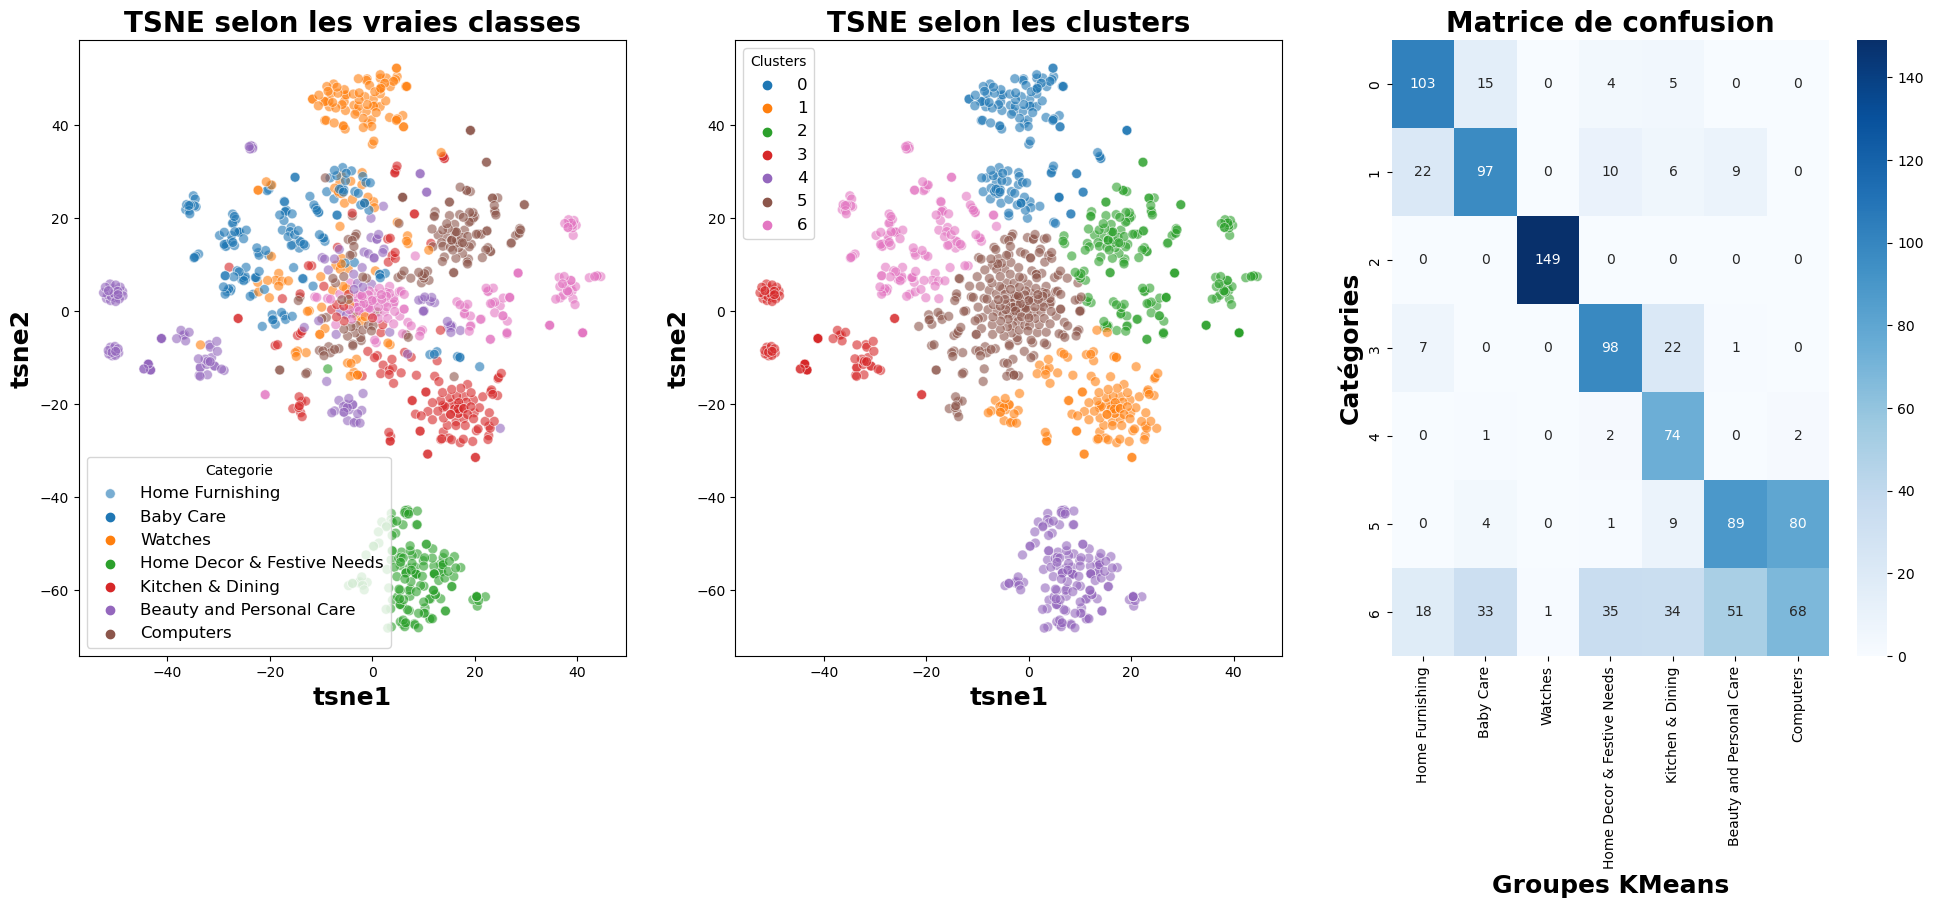

L'indice de Rand ajusté (ARI) pour ce modèle d'extraction de caractéristiques est de 0.421.


In [319]:
# Réduire la dimensionnalité
tsne_data = reduce_dimensionality_tsne(reduced_data)

# Appeler la fonction pour afficher les graphiques et les cluster
plot_tsne_and_kmeans_clusters(tsne_data)

### TF-IDF

**TF-IDF (Term Frequency-Inverse Document Frequency)** est une technique d'évaluation de l'importance d'un mot dans un document par rapport à un corpus de documents. Contrairement au simple comptage des mots (CountVectorizer), TF-IDF prend en compte non seulement la fréquence d'un mot dans un document (TF), mais aussi la fréquence inverse du mot dans l'ensemble du corpus (IDF), ce qui permet de réduire l'importance des mots courants et de mettre en avant les mots plus significatifs pour chaque document.

### Extraction des features

In [320]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialiser le vecteur TF-IDF et l'ajuster sur le texte tokenisé
tfidf_vectorizer = TfidfVectorizer().fit(df['DescriptionCompleteTokenizer'])

# Transformer le texte en une matrice sparse TF-IDF
tfidf_sparse_matrix = tfidf_vectorizer.transform(df['DescriptionCompleteTokenizer'])

tfidf_sparse_matrix

<1050x4109 sparse matrix of type '<class 'numpy.float64'>'
	with 32606 stored elements in Compressed Sparse Row format>

### Réduction dimensionnelle et analyse graphique des clusters

**Le TruncatedSVD** (Singular Value Decomposition tronquée) est une technique de réduction de dimensionnalité utilisée principalement pour les matrices creuses (sparse matrices). Il est particulièrement utile dans le traitement du langage naturel et l'analyse de texte lorsque les données sont représentées sous forme de grandes matrices creuses, comme celles générées par des techniques de bag-of-words ou de TF-IDF.

In [321]:
# Réduction dimensionnelle (PCA n'étant pas adapté aux matrices sparse)
svd_model = TruncatedSVD(n_components=1000, random_state=42)
reduced_data = svd_model.fit_transform(tfidf_sparse_matrix)

reduced_data

array([[ 3.40684761e-02,  1.68886581e-01, -1.07844918e-01, ...,
         4.06575815e-18,  8.60585474e-18, -6.50521303e-19],
       [ 5.88041164e-02,  1.30449568e-01, -1.67242254e-01, ...,
         8.23993651e-18,  1.14925430e-17,  9.97465999e-18],
       [ 5.36954704e-02,  1.43188100e-01, -1.58699033e-01, ...,
         3.17129135e-18,  7.31836466e-19, -3.68628739e-18],
       ...,
       [ 5.22384639e-02,  2.87882672e-02, -4.40209915e-02, ...,
        -1.30104261e-18,  1.08420217e-18,  8.67361738e-19],
       [ 7.75798797e-02,  4.95486155e-02, -7.27309126e-02, ...,
         5.96311195e-18,  3.46944695e-18,  3.46944695e-18],
       [ 8.46578731e-02,  4.62472347e-02, -7.11171594e-02, ...,
         1.21430643e-17,  8.67361738e-19, -5.20417043e-18]])

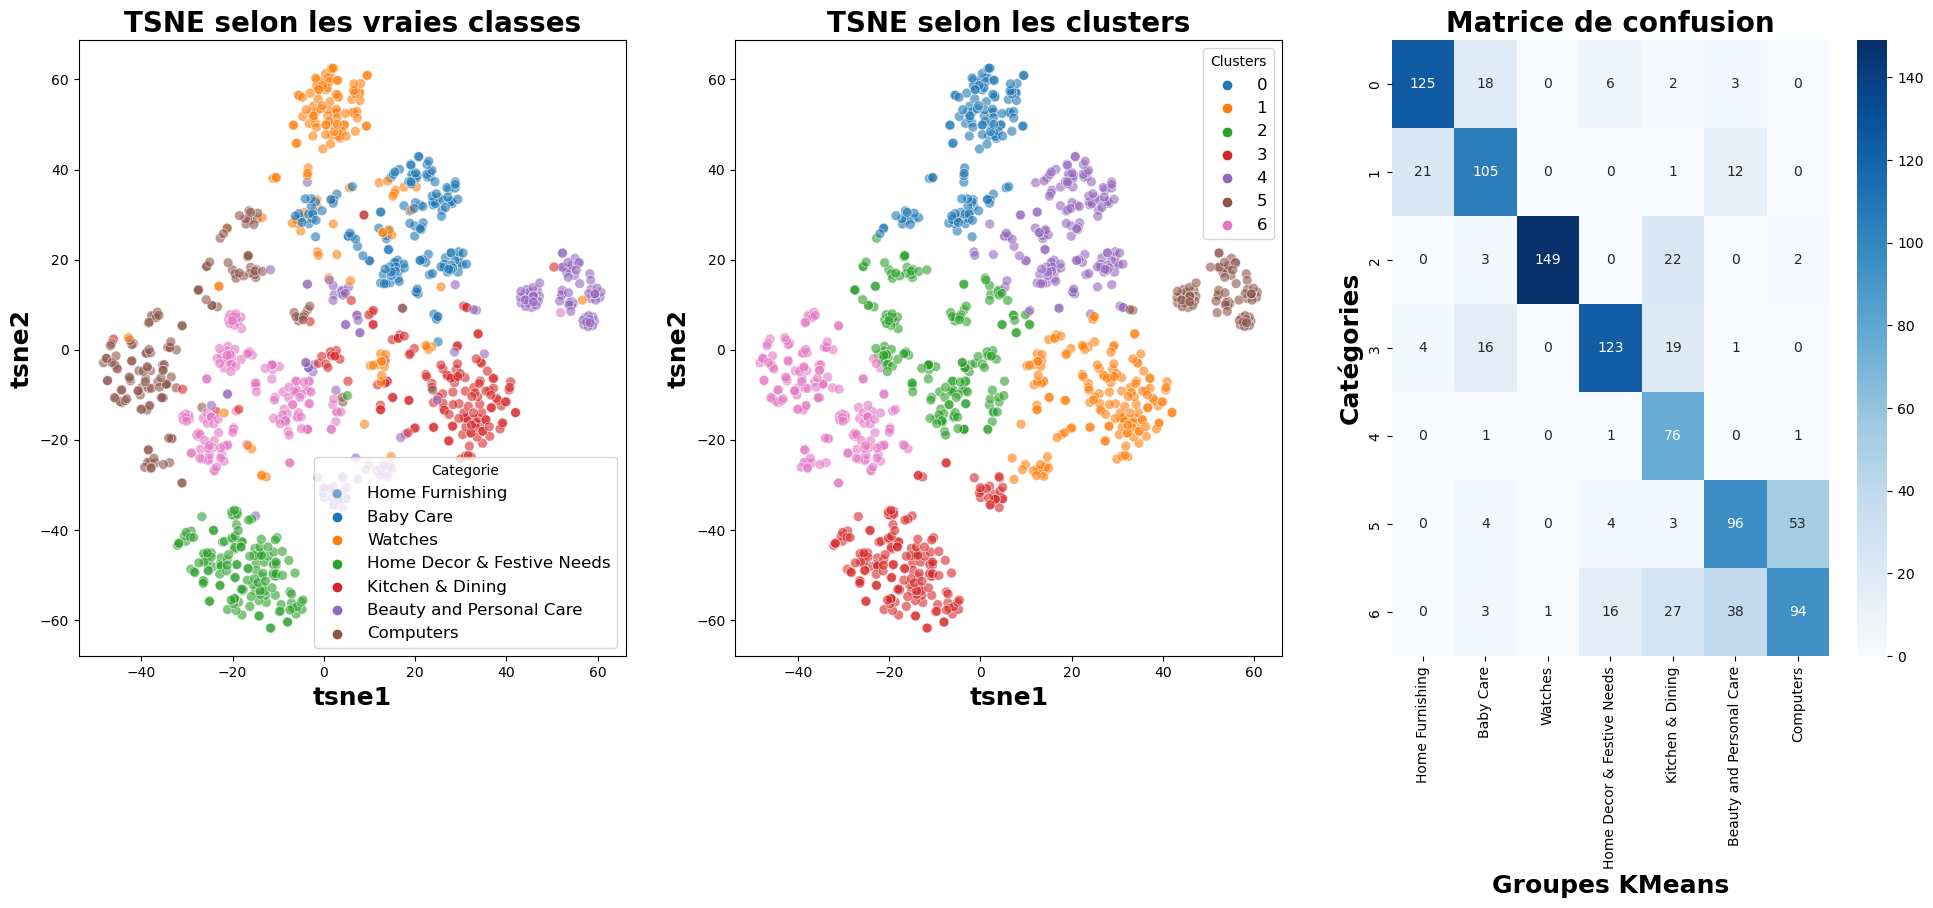

L'indice de Rand ajusté (ARI) pour ce modèle d'extraction de caractéristiques est de 0.519.


In [322]:
# Réduire la dimensionnalité
tsne_data = reduce_dimensionality_tsne(reduced_data)

# Appeler la fonction pour afficher les graphiques et les cluster
plot_tsne_and_kmeans_clusters(tsne_data)

## Approche Word2Vec 

L'approche **Word2Vec** est une méthode avancée pour représenter des mots sous forme de vecteurs continus dans un espace vectoriel de dimension réduite. Contrairement à l'approche Bag-of-words qui compte simplement les occurrences de mots, Word2Vec capture les relations sémantiques entre les mots en les représentant sous forme de vecteurs de taille fixe, où des mots similaires ont des vecteurs similaires.

### Embedding classique

### Extraction des features

In [323]:
# Obtenir le nombre de cœurs du processeur
num_cores = multiprocessing.cpu_count()

# Afficher le nombre de cœurs
print("Nombre de cœurs de l'ordinateur : ", num_cores)

Nombre de cœurs de l'ordinateur :  4


In [324]:
# Prétraiter la colonne 'DescriptionComplete' pour obtenir une liste de mots tokenisés
df['Word2Vec_tokenized_description'] = df['DescriptionComplete'].apply(lambda x: gensim.utils.simple_preprocess(x))

# Paramètres du modèle Word2Vec :
# vector_size : Nombre de dimensions des vecteurs d'embeddings (par défaut 100).
# window : Distance maximale entre le mot cible et les mots contextuels (par défaut 5).
# min_count : Nombre minimal d'occurrences pour qu'un mot soit pris en compte (par défaut 5).
# workers : Nombre de threads utilisés pour l'entraînement (par défaut 3).
# sg : Algorithme d'entraînement utilisé, 0 pour CBOW et 1 pour Skip-gram (par défaut 0).

# Entraîner le modèle Word2Vec
word2vec_model = Word2Vec(sentences=df['Word2Vec_tokenized_description'], vector_size=100, window=5, min_count=2)

# Obtenir le vocabulaire du modèle
vocabulary = set(word2vec_model.wv.index_to_key)

# Transformer les descriptions tokenisées en vecteurs Word2Vec
word_vectors = []
for words in df['Word2Vec_tokenized_description']:
    vector_list = [word2vec_model.wv[word] for word in words if word in vocabulary]
    word_vectors.append(vector_list)

# Calculer la moyenne des vecteurs de mots pour chaque description
averaged_word2vec_vectors = []
for vector_list in word_vectors:
    if vector_list:
        averaged_word2vec_vectors.append(np.mean(vector_list, axis=0))
    else:
        averaged_word2vec_vectors.append(np.zeros(100, dtype=float))

# Convertir les vecteurs moyennés en DataFrame
averaged_word2vec_vectors_df = pd.DataFrame(averaged_word2vec_vectors)

# Afficher le DataFrame résultant
averaged_word2vec_vectors_df

0         1         2         3         4         5         6   \
0    -0.338774  0.373035 -0.045821 -0.314308  0.307378 -0.467452  0.128376   
1    -0.388689  0.361051 -0.147851 -0.598221  0.484696 -0.536602  0.051693   
2    -0.336591  0.374034 -0.046163 -0.295628  0.315532 -0.492347  0.099756   
3    -0.344125  0.283063 -0.018662 -0.538051  0.458358 -0.427472  0.106991   
4    -0.358751  0.338840  0.001473 -0.407659  0.397571 -0.463533  0.135758   
...        ...       ...       ...       ...       ...       ...       ...   
1045 -0.289387  0.364882  0.037711 -0.040284  0.156810 -0.454787  0.137140   
1046 -0.348760  0.439962  0.054976 -0.081187  0.204211 -0.546513  0.172689   
1047 -0.156804  0.316747  0.273072  0.462380 -0.173344 -0.547143 -0.098322   
1048 -0.207627  0.411607  0.358823  0.589414 -0.220164 -0.717365 -0.131228   
1049 -0.206393  0.424126  0.383829  0.652056 -0.252587 -0.737155 -0.137879   

            7         8         9         10        11        12        13  \
0     0.666507 -0.135907 -0.025472 -0.608542 -0.219780  0.061420 -0.263726   
1     0.648922 -0.340789  0.259766 -0.860404 -0.251420  0.158175 -0.205447   
2     0.665112 -0.140027 -0.018928 -0.626262 -0.222637  0.088582 -0.211488   
3     0.511853 -0.333491  0.242053 -0.673376 -0.352742  0.136203 -0.204739   
4     0.611089 -0.223362  0.089754 -0.651601 -0.312575  0.093856 -0.245930   
...        ...       ...       ...       ...       ...       ...       ...   
1045  0.678376  0.030766 -0.257355 -0.416565 -0.213134  0.022390 -0.218718   
1046  0.809470  0.034388 -0.291627 -0.519553 -0.245839  0.039817 -0.287355   
1047  0.834596 -0.279915 -0.393197 -0.343319 -0.516635  0.410216  0.262114   
1048  1.090085 -0.370579 -0.504304 -0.456103 -0.673451  0.538983  0.331389   
1049  1.131437 -0.377157 -0.547321 -0.448029 -0.708373  0.562253  0.362912   

            14        15        16        17        18        19        20  \
0    -0.065717 -0.555032 -0.305503 -0.439891  0.210147 -0.429432  0.399026   
1     0.166887 -0.864625 -0.347059 -0.539507  0.196730 -0.397575  0.610083   
2    -0.015233 -0.539201 -0.286560 -0.441942  0.193583 -0.411139  0.411396   
3     0.154961 -0.821313 -0.259509 -0.552362  0.191973 -0.357036  0.558996   
4     0.040613 -0.705890 -0.282571 -0.530613  0.210274 -0.404876  0.492642   
...        ...       ...       ...       ...       ...       ...       ...   
1045 -0.176199 -0.234554 -0.227784 -0.350412  0.188321 -0.405454  0.213574   
1046 -0.207303 -0.311518 -0.284618 -0.434932  0.240991 -0.504879  0.264802   
1047 -0.034707 -0.074303  0.177770 -0.571439  0.152699 -0.960123  0.440667   
1048 -0.038363 -0.117750  0.228520 -0.757736  0.206706 -1.263357  0.584790   
1049 -0.049764 -0.081535  0.254829 -0.776235  0.209075 -1.316213  0.594680   

            21        22        23        24        25        26        27  \
0    -0.110357  0.305619  0.009178  0.019622 -0.281348  0.014736 -0.248408   
1    -0.247420  0.408327 -0.169658  0.302239 -0.553427 -0.040548 -0.374519   
2    -0.089610  0.291719  0.010858  0.067567 -0.258261 -0.039557 -0.249894   
3    -0.206714  0.217990 -0.196014  0.244478 -0.538249  0.121243 -0.386646   
4    -0.135369  0.236946 -0.080610  0.125102 -0.407277  0.083408 -0.333950   
...        ...       ...       ...       ...       ...       ...       ...   
1045  0.054778  0.172859  0.150010 -0.136171  0.003181 -0.046852 -0.110376   
1046  0.050486  0.226858  0.178410 -0.172476 -0.012733 -0.019435 -0.141908   
1047  0.168338 -0.204118  0.083150 -0.070771  0.244368 -0.423466 -0.321277   
1048  0.211465 -0.256958  0.100073 -0.083688  0.303510 -0.539256 -0.432365   
1049  0.238001 -0.291848  0.117624 -0.104951  0.348738 -0.575431 -0.437184   

            28        29        30        31        32        33        34  \
0    -0.395093 -0.038746  0.242963  0.024234 -0.313647 -0.113420  0.077925   
1    -0.777641 -0.187706  0.141224  0.413364 -0.429360 -0.269812  0.276987   
2    -0.415647 -0.043214  0.23

### Réduction dimensionnelle et analyse graphique des clusters

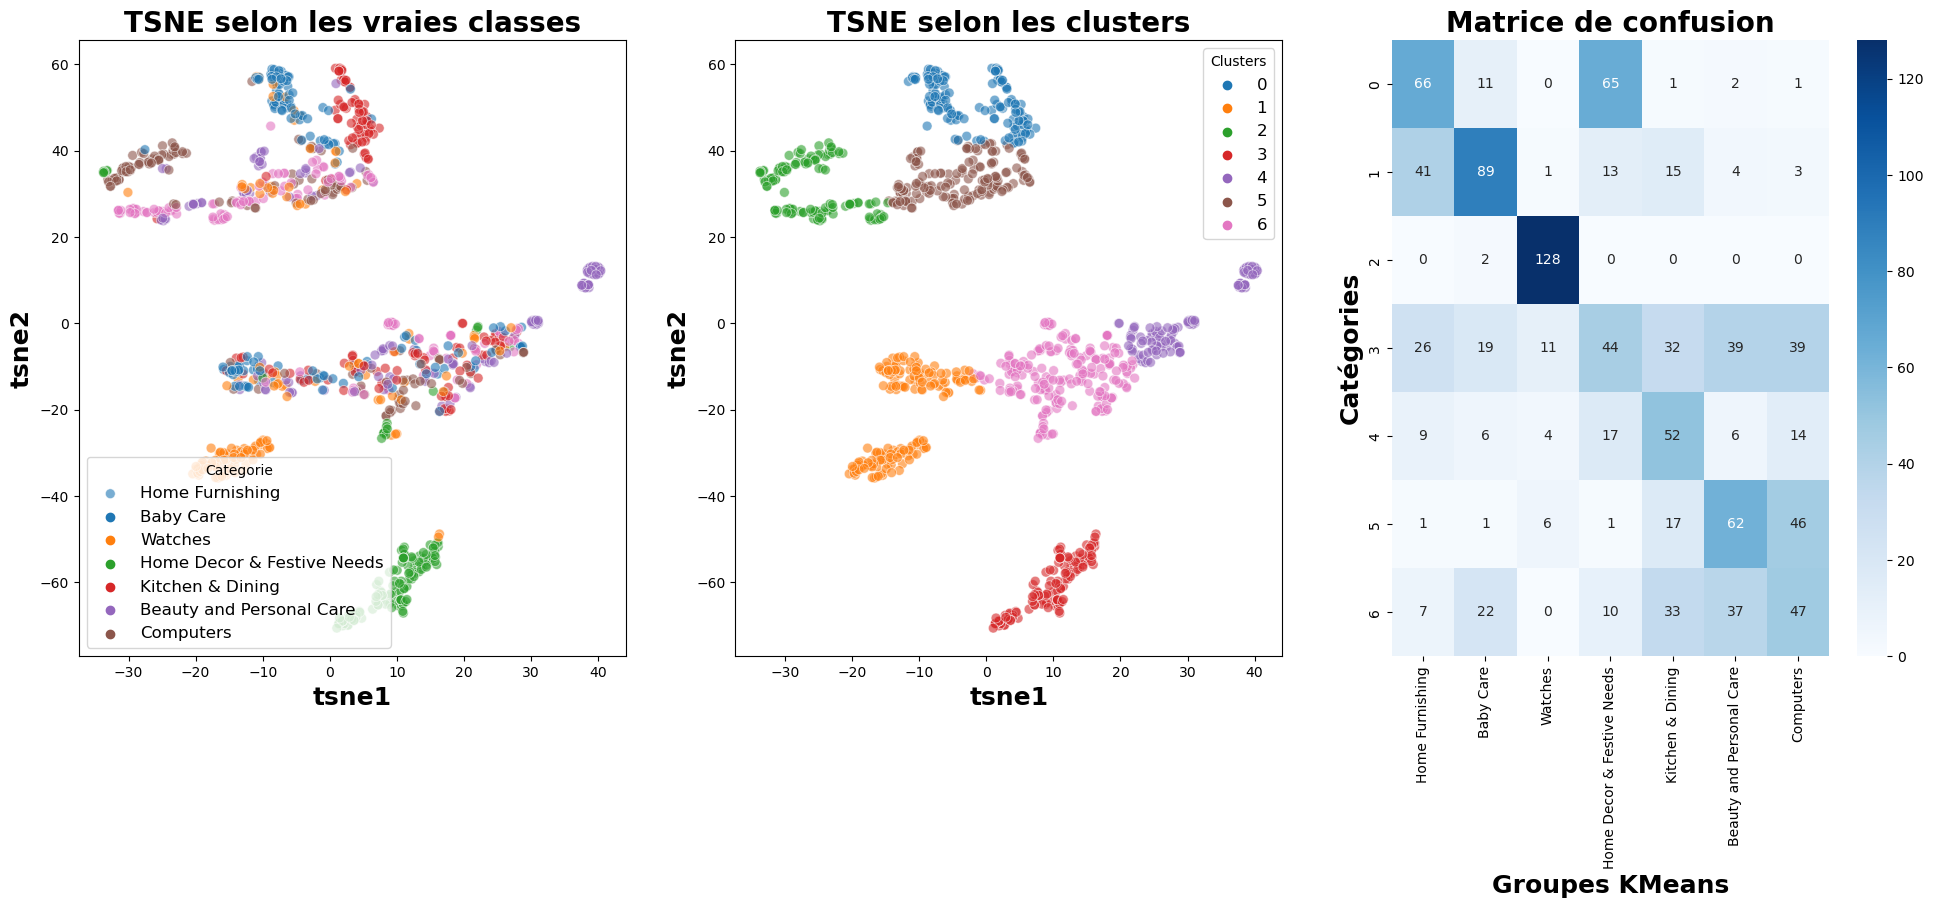

L'indice de Rand ajusté (ARI) pour ce modèle d'extraction de caractéristiques est de 0.242.


In [325]:
# Réduire la dimensionnalité
tsne_data = reduce_dimensionality_tsne(averaged_word2vec_vectors_df)

# Appeler la fonction pour afficher les graphiques et les cluster
plot_tsne_and_kmeans_clusters(tsne_data)

## Approche BERT

L'approche **BERT (Bidirectional Encoder Representations from Transformers)** est une méthode avancée pour obtenir des représentations contextuelles de mots et de phrases. Contrairement aux modèles traditionnels comme Word2Vec, BERT prend en compte le contexte des mots dans les deux directions (avant et arrière) pour capturer des significations plus riches et plus précises.

### Extraction des features

In [326]:
# Division de la DataFrame en deux parties en utilisant StratifiedKFold
# Cette étape est nécessaire car BERT est trop lourd pour être exécuté sur les CPU disponibles

# Initialiser StratifiedKFold pour diviser les données en 2 parties tout en conservant la proportion des classes
stratified_kfold = StratifiedKFold(n_splits=2)

# Variables pour stocker les deux parties de la DataFrame
part1_df = None
part2_df = None

# Diviser les données en utilisant StratifiedKFold
for part1_index, part2_index in stratified_kfold.split(df['DescriptionComplete'], df['Category_Level_1']):
    part1_df = df.loc[part1_index, :]
    part2_df = df.loc[part2_index, :]

# Afficher la distribution des classes dans chaque partie
part1_class_distribution = part1_df['Category_Level_1'].value_counts()
part2_class_distribution = part2_df['Category_Level_1'].value_counts()

# Afficher les distributions
print("Distribution des classes dans la première partie:")
print(part1_class_distribution)
print("\nDistribution des classes dans la deuxième partie:")
print(part2_class_distribution)

Distribution des classes dans la première partie:
0    75
1    75
2    75
3    75
4    75
5    75
6    75
Name: Category_Level_1, dtype: int64

Distribution des classes dans la deuxième partie:
4    75
3    75
5    75
6    75
2    75
1    75
0    75
Name: Category_Level_1, dtype: int64


**Nombre égal dans chaque catégorie.**
Les classes sont bien réparties de manière égale dans les deux parties du dataframe.

In [327]:
import time
from transformers import AutoTokenizer, TFAutoModel

def extraire_caracteristiques_textuelles_avec_bert(df):
    """
    Extraire les caractéristiques textuelles en utilisant le modèle BERT.

    Paramètres:
    df (pd.DataFrame): DataFrame contenant une colonne 'DescriptionComplete' avec des données textuelles.

    Retourne:
    np.ndarray: Caractéristiques extraites du modèle BERT.
    """
    
    # Extraction des phrases du DataFrame
    phrases = df['DescriptionComplete'].values.tolist()
    taille_lot = 10  # Taille du batch
    longueur_max = 64  # Longueur maximale des séquences
    nom_modele = 'bert-base-uncased'  # Type de modèle BERT
    
    # Chargement du tokenizer et du modèle BERT
    tokenizer = AutoTokenizer.from_pretrained(nom_modele)
    modele = TFAutoModel.from_pretrained(nom_modele)
    
    # Enregistrement du temps de début
    debut_temps = time.time()

    # Traitement des phrases par lots
    for etape in range(len(phrases) // taille_lot):
        idx_debut_lot = etape * taille_lot
        
        ids_entree = []
        ids_type_token = []
        masques_attention = []

        # Tokenisation des phrases dans le lot
        for phrase in phrases[idx_debut_lot:idx_debut_lot + taille_lot]:
            entree_encodee = tokenizer.encode_plus(
                phrase,
                add_special_tokens=True,
                max_length=longueur_max,
                padding='max_length',
                return_attention_mask=True, 
                return_token_type_ids=True,
                truncation=True,
                return_tensors='tf'
            )

            ids_entree.append(entree_encodee['input_ids'][0])
            ids_type_token.append(entree_encodee['token_type_ids'][0])
            masques_attention.append(entree_encodee['attention_mask'][0])

        ids_entree = np.asarray(ids_entree)
        ids_type_token = np.asarray(ids_type_token)
        masques_attention = np.asarray(masques_attention)
        
        # Création d'un dictionnaire avec les textes prétraités
        texte_pretraite = {
            "input_ids": ids_entree, 
            "attention_mask": masques_attention, 
            "token_type_ids": ids_type_token
        }
        
        # Obtention des sorties du modèle BERT
        sorties_modele = modele(texte_pretraite)
        derniers_etats_caches = sorties_modele[0]
             
        if etape == 0:
            tous_etats_caches = derniers_etats_caches
        else:
            tous_etats_caches = np.concatenate((tous_etats_caches, derniers_etats_caches), axis=0)
    
    # Calcul de la moyenne des derniers états cachés
    caracteristiques_bert = np.mean(tous_etats_caches, axis=1)
    
    # Enregistrement du temps de fin et calcul du temps écoulé
    fin_temps = np.round(time.time() - debut_temps, 0)
    print("Temps de traitement : ", fin_temps, "secondes")
    
    return caracteristiques_bert

In [328]:
features_bert = extraire_caracteristiques_textuelles_avec_bert(df)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Temps de traitement :  151.0 secondes


In [329]:
# Afficher la forme des arrays
print(features_bert.shape)

(1050, 768)


### Réduction dimensionnelle et analyse graphique des clusters

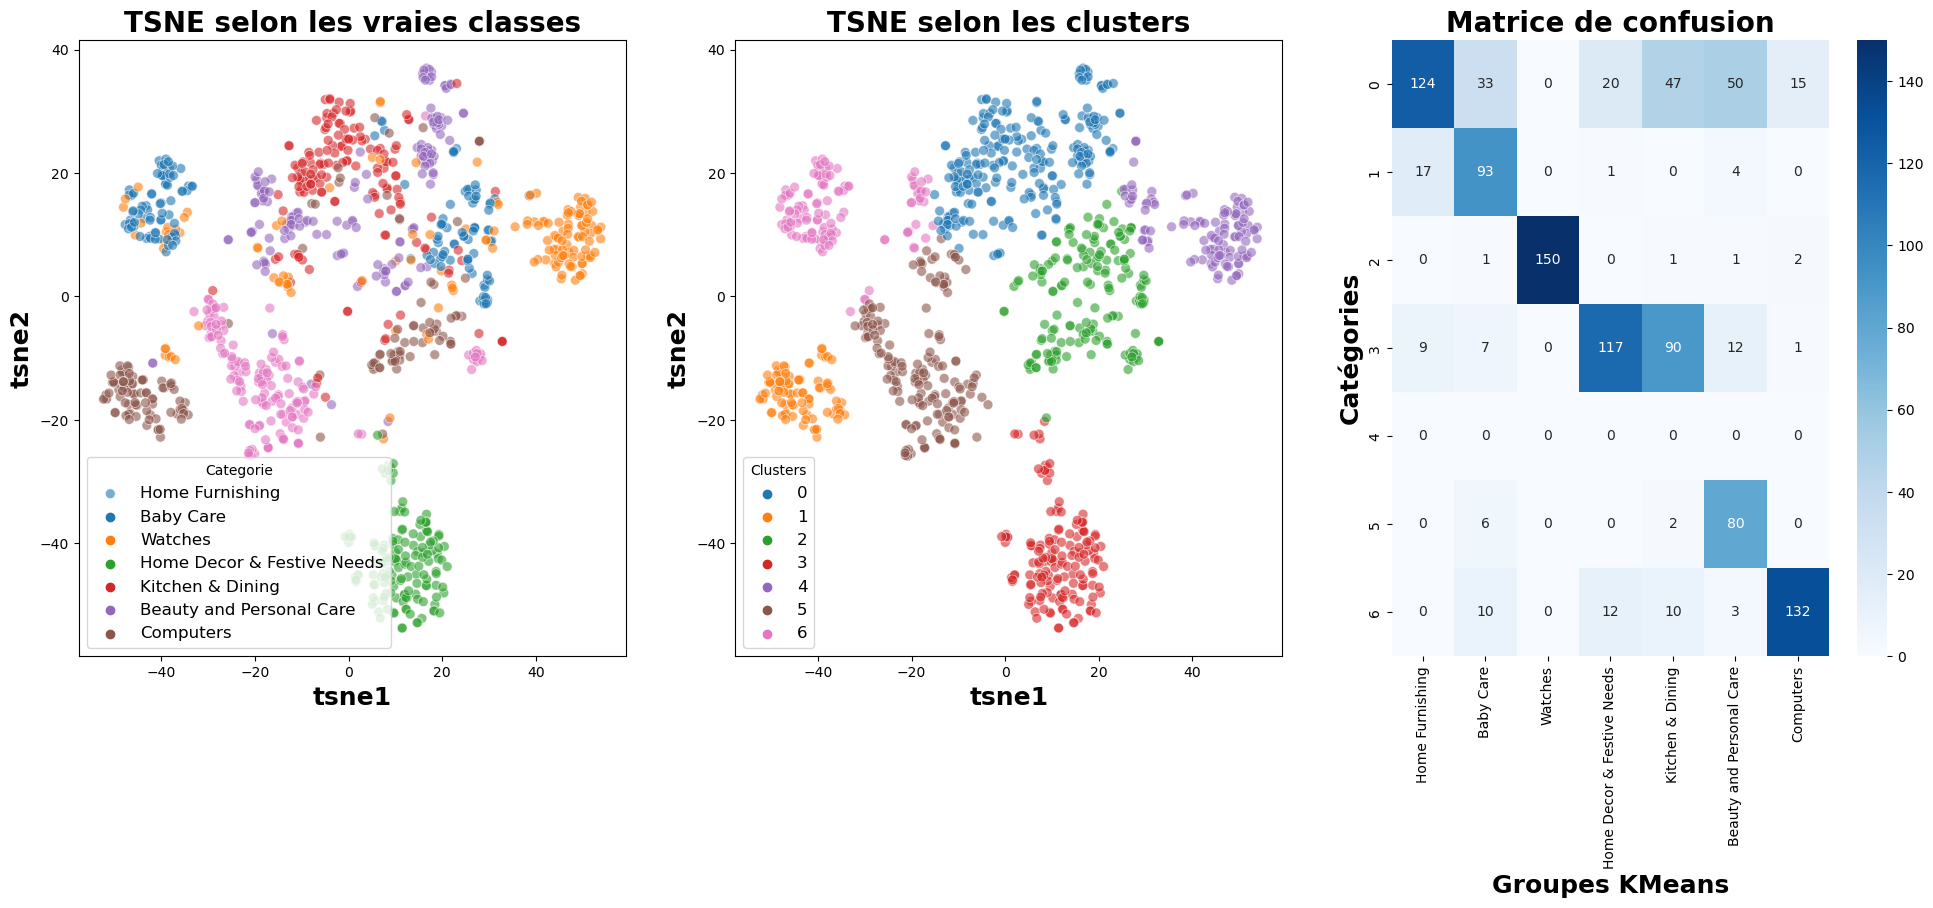

L'indice de Rand ajusté (ARI) pour ce modèle d'extraction de caractéristiques est de 0.468.


In [330]:
# Réduction des dimensions avec PCA
# 'arr' contient les états cachés extraits de BERT
# On commence par aplatir les états cachés en une matrice 2D (525 échantillons, chacun ayant 768 dimensions)
flattened_data = pd.DataFrame(features_bert.reshape(1050, 768))

# Appliquer PCA pour réduire les dimensions tout en conservant 99% de la variance
pca_reduced_data = reduce_dimensionality_pca(flattened_data, 0.99)

# Appliquer t-SNE pour une visualisation en 2D
tsne_transformed_data = reduce_dimensionality_tsne(pca_reduced_data)

# Afficher les graphiques des clusters et calculer le score ARI
plot_tsne_and_kmeans_clusters(tsne_transformed_data)

## Approche USE

L'approche **USE (Universal Sentence Encoder)** est une méthode avancée pour obtenir des représentations vectorielles de phrases et de textes. Développé par Google, USE produit des embeddings de haute qualité pour des phrases entières plutôt que des mots individuels. Il est particulièrement utile pour des tâches telles que la classification de texte, la similarité de texte et le clustering de texte.

### Extraction des features

In [331]:
import tensorflow as tf
import tensorflow_hub as hub
import os
import tarfile

# Chemin vers l'archive téléchargée
local_model_path = r"C:\Users\Infogene\Documents\Khoty_Privé\DOSSIER FORMATION DATA SCIENTIST\PROJET 6\archive.tar.gz"
extracted_model_path = r"C:\Users\Infogene\Documents\Khoty_Privé\DOSSIER FORMATION DATA SCIENTIST\PROJET 6\extracted_model"

# Extraire l'archive tar.gz
if not os.path.exists(extracted_model_path):
    os.makedirs(extracted_model_path)
    with tarfile.open(local_model_path, 'r:gz') as tar:
        tar.extractall(path=extracted_model_path)

# Charger le modèle Universal Sentence Encoder depuis le chemin local extrait
embed = hub.load(extracted_model_path)

# Appliquer l'encodage USE à la colonne 'DescriptionCompleteTokenizer'
sentences = df['DescriptionCompleteTokenizer'].tolist()
embeddings = embed(sentences)

# Convertir les embeddings en DataFrame pour une analyse ultérieure
embeddings_df = pd.DataFrame(embeddings.numpy())

# Afficher le DataFrame résultant
embeddings_df

0         1         2         3         4         5         6    \
0    -0.056900 -0.055884  0.024777  0.051274 -0.025428  0.005560 -0.003274   
1    -0.045888 -0.030619  0.009958  0.030758  0.046606  0.059890  0.050018   
2    -0.054185 -0.047169 -0.041173  0.054108  0.051960  0.055114  0.052701   
3    -0.056918 -0.056241  0.053026  0.041883  0.056531  0.037843  0.018228   
4    -0.053433 -0.050493  0.052383  0.048631  0.053453  0.036025  0.031248   
...        ...       ...       ...       ...       ...       ...       ...   
1045 -0.049043 -0.035552 -0.040362  0.051281 -0.042762  0.049319 -0.045609   
1046 -0.059630  0.018660  0.039962  0.056629  0.023670  0.042034 -0.035333   
1047  0.013828 -0.056825  0.056367  0.029820 -0.005534  0.052780 -0.060470   
1048 -0.008882 -0.037847  0.062931  0.051630  0.050581  0.036817 -0.065340   
1049 -0.037916 -0.066671  0.055501  0.054297  0.036137  0.050263 -0.052891   

           7         8         9         10        11        12        13   \
0     0.054892 -0.050546  0.004385 -0.043074 -0.001388  0.023480 -0.057661   
1    -0.023201 -0.005561 -0.044719 -0.030233  0.052642 -0.050099 -0.055921   
2     0.020008 -0.030002  0.032647 -0.044638  0.052755 -0.032505 -0.055187   
3     0.014960  0.025531 -0.045638 -0.004072  0.056879 -0.012081 -0.052755   
4     0.050435 -0.000892 -0.037911 -0.046332  0.053574 -0.040488 -0.053554   
...        ...       ...       ...       ...       ...       ...       ...   
1045  0.038795 -0.051426  0.051384 -0.041701 -0.041388 -0.040008 -0.051426   
1046  0.058782  0.008973  0.021449 -0.059930  0.037661 -0.019113 -0.051230   
1047  0.011990  0.011440 -0.054345 -0.056765 -0.008684  0.010118  0.044936   
1048  0.023252 -0.001716 -0.065392 -0.050297 -0.059967 -0.064756  0.041260   
1049 -0.011250  0.037938 -0.073021 -0.039928 -0.056267 -0.057095  0.046443   

           14        15        16        17        18        19        20   \
0     0.054374  0.056174  0.056495  0.017897  0.056999  0.040431 -0.049120   
1     0.059444 -0.056828  0.056013 -0.050963  0.041082  0.046326 -0.004008   
2     0.055089 -0.025742  0.054274 -0.050837  0.015926  0.038525 -0.002178   
3     0.056173  0.056094  0.055835  0.033437 -0.045234  0.052726 -0.029380   
4     0.053476  0.053561  0.053162  0.011793 -0.036331  0.046087 -0.043205   
...        ...       ...       ...       ...       ...       ...       ...   
1045  0.051015  0.051425  0.050944  0.051425  0.051276 -0.049316 -0.006066   
1046  0.013472  0.055343  0.033409 -0.012695 -0.050918 -0.035238 -0.047345   
1047 -0.016201  0.013674  0.028690 -0.028916  0.057992  0.018855 -0.043082   
1048 -0.004352  0.005361  0.035790 -0.063651  0.060981 -0.012828 -0.051176   
1049  0.008076 -0.010101 -0.002106 -0.062841  0.053863  0.044614 -0.037683   

           21        22        23        24        25        26        27   \
0    -0.019847  0.006239 -0.056280 -0.018068 -0.051278  0.041237  0.020035   
1     0.032450  0.049534 -0.059792  0.022907  0.035765 -0.000960  0.038409   
2     0.050446  0.053018 -0.055161  0.053701  0.021065 -0.045104  0.021712   
3     0.033717  0.054960 -0.056834  0.037642  0.052391 -0.012933 -0.042398   
4     0.043760  0.051683 -0.053557  0.052746  0.034458  0.022930 -0.004582   
...        ...       ...       ...       ...       ...       ...       ...   
1045  0.021865 -0.032203 -0.050600  0.043932  0.051409 -0.044207 -0.051120   
1046 -0.034709  0.027549 -0.060311 -0.029189  0.058991 -0.054377 -0.043081   
1047 -0.070655  0.016226 -0.041684  0.060239 -0.002709 -0.011121 -0.045999   
1048 -0.036495  0.012886 -0.046792 -0.052175 -0.019372  0.009476  0.005048   
1049 -0.035219  0.004370 -0.011425 -0.070018 -0.000024  0.036782 -0.009123   

           28        29        30        31        32        33        34   \
0     0.053233  0.039108  0.057872  0.013233  0.047124 -0.053186  0.035751   
1     0.043580 -0.048122  0.059892 -0.043086  0.043974 -0.034831 -0.037498   
2     0.039894 -0.054412  0.0

### Réduction dimensionnelle et analyse graphique des clusters

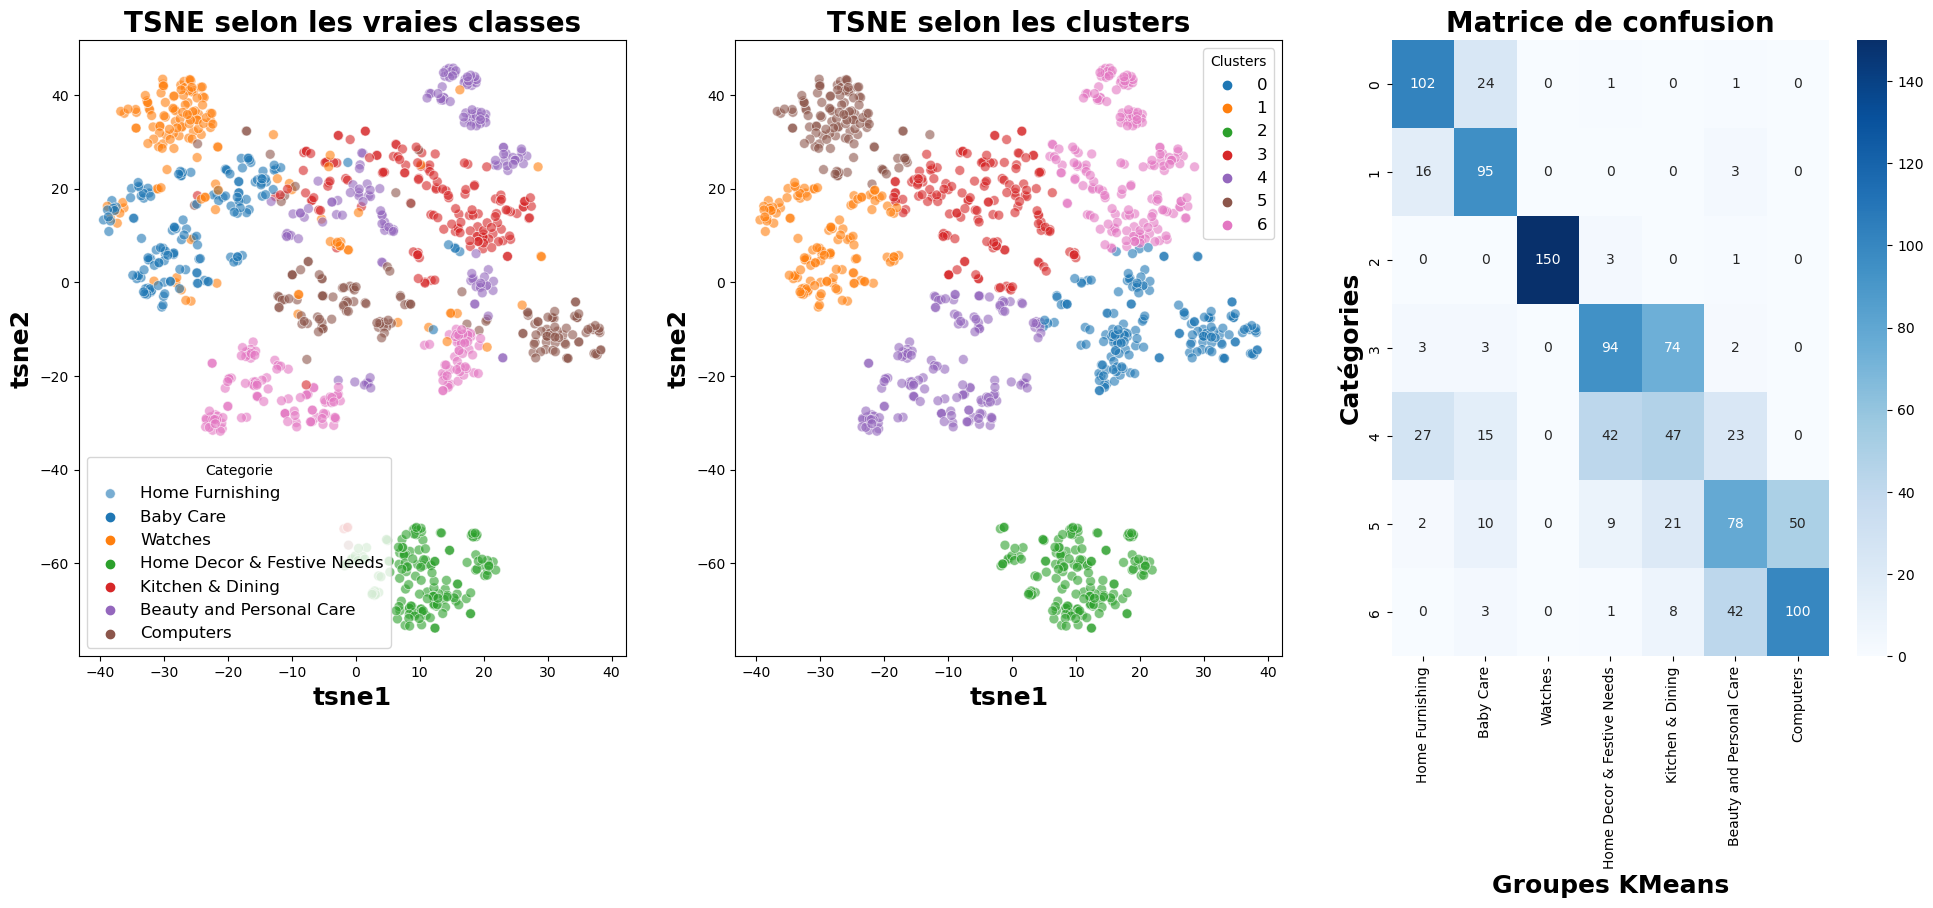

L'indice de Rand ajusté (ARI) pour ce modèle d'extraction de caractéristiques est de 0.443.


In [332]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Réduction des dimensions avec PCA
# Appliquer PCA pour réduire les dimensions tout en conservant 99% de la variance
pca_reduced_embeddings = reduce_dimensionality_pca(embeddings_df, 0.99)

# Appliquer t-SNE pour une visualisation en 2D
tsne_transformed_embeddings = reduce_dimensionality_tsne(pca_reduced_embeddings)

# Afficher les graphiques des clusters et calculer le score ARI
plot_tsne_and_kmeans_clusters(tsne_transformed_embeddings)

In [333]:
# Exporter les embeddings du modèle USE
use_embeddings_filepath = 'VariablesUSE.csv'

# Sauvegarder les embeddings 
embeddings_df.to_csv(use_embeddings_filepath, index=False)

### Observation BERT et USE

   - **BERT** : Avec un ARI de 0.466, le modèle BERT semble mieux capturer les nuances des descriptions textuelles des articles pour les catégoriser correctement par rapport à USE.
   - **USE** : Un ARI de 0.434 est toujours un résultat prometteur, bien que légèrement inférieur à BERT, ce qui suggère que USE est également efficace pour cette tâche mais avec une précision légèrement moindre.

# L’Etat de l’art

## Approche DeBERTa

### Utilisation de DeBERTa avec un Modèle de base (deberta-base)


- **DeBERTa-base :** Un modèle DeBERTa plus petit avec environ 110 millions de paramètres. Il possède 12 couches de transformateurs, 12 têtes d'attention, et une taille d'embedding de 768. Ce modèle est moins gourmand en ressources, plus rapide à entraîner et à utiliser, mais offre des performances légèrement inférieures par rapport à DeBERTa-large, particulièrement adapté pour des tâches NLP standard et des environnements avec des ressources limitées.

In [334]:
import time
from transformers import AutoTokenizer, TFAutoModel

def extraire_caracteristiques_textuelles_avec_deberta(df):
    """
    Extraire les caractéristiques textuelles en utilisant le modèle DeBERTa.

    Paramètres:
    df (pd.DataFrame): DataFrame contenant une colonne 'DescriptionComplete' avec des données textuelles.

    Retourne:
    np.ndarray: Caractéristiques extraites du modèle DeBERTa.
    """
    
    # Extraction des phrases du DataFrame
    phrases = df['DescriptionComplete'].values.tolist()
    taille_lot = 10  # Taille du batch
    longueur_max = 64  # Longueur maximale des séquences
    nom_modele = 'microsoft/deberta-base'  # Type de modèle DeBERTa
    
    # Chargement du tokenizer et du modèle DeBERTa
    tokenizer = AutoTokenizer.from_pretrained(nom_modele)
    modele = TFAutoModel.from_pretrained(nom_modele)
    
    # Enregistrement du temps de début
    debut_temps = time.time()

    # Traitement des phrases par lots
    for etape in range(len(phrases) // taille_lot):
        idx_debut_lot = etape * taille_lot
        
        ids_entree = []
        ids_type_token = []
        masques_attention = []

        # Tokenisation des phrases dans le lot
        for phrase in phrases[idx_debut_lot:idx_debut_lot + taille_lot]:
            entree_encodee = tokenizer.encode_plus(
                phrase,
                add_special_tokens=True,
                max_length=longueur_max,
                padding='max_length',
                return_attention_mask=True, 
                return_token_type_ids=True,
                truncation=True,
                return_tensors='tf'
            )

            ids_entree.append(entree_encodee['input_ids'][0])
            ids_type_token.append(entree_encodee['token_type_ids'][0])
            masques_attention.append(entree_encodee['attention_mask'][0])

        ids_entree = np.asarray(ids_entree)
        ids_type_token = np.asarray(ids_type_token)
        masques_attention = np.asarray(masques_attention)
        
        # Création d'un dictionnaire avec les textes prétraités
        texte_pretraite = {
            "input_ids": ids_entree, 
            "attention_mask": masques_attention, 
            "token_type_ids": ids_type_token
        }
        
        # Obtention des sorties du modèle DeBERTa
        sorties_modele = modele(texte_pretraite)
        derniers_etats_caches = sorties_modele[0]
             
        if etape == 0:
            tous_etats_caches = derniers_etats_caches
        else:
            tous_etats_caches = np.concatenate((tous_etats_caches, derniers_etats_caches), axis=0)
    
    # Calcul de la moyenne des derniers états cachés
    caracteristiques_deberta = np.mean(tous_etats_caches, axis=1)
    
    # Enregistrement du temps de fin et calcul du temps écoulé
    fin_temps = np.round(time.time() - debut_temps, 0)
    print("Temps de traitement : ", fin_temps, "secondes")
    
    return caracteristiques_deberta

### Extraction des features

In [335]:
# Extraire les caractéristiques avec DeBERTa
features_deberta = extraire_caracteristiques_textuelles_avec_deberta(df)

# Afficher la forme des arrays
print(features_deberta.shape)

All model checkpoint layers were used when initializing TFDebertaModel.

All the layers of TFDebertaModel were initialized from the model checkpoint at microsoft/deberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaModel for predictions without further training.


Temps de traitement :  183.0 secondes
(1050, 768)


### Réduction dimensionnelle et analyse graphique des clusters

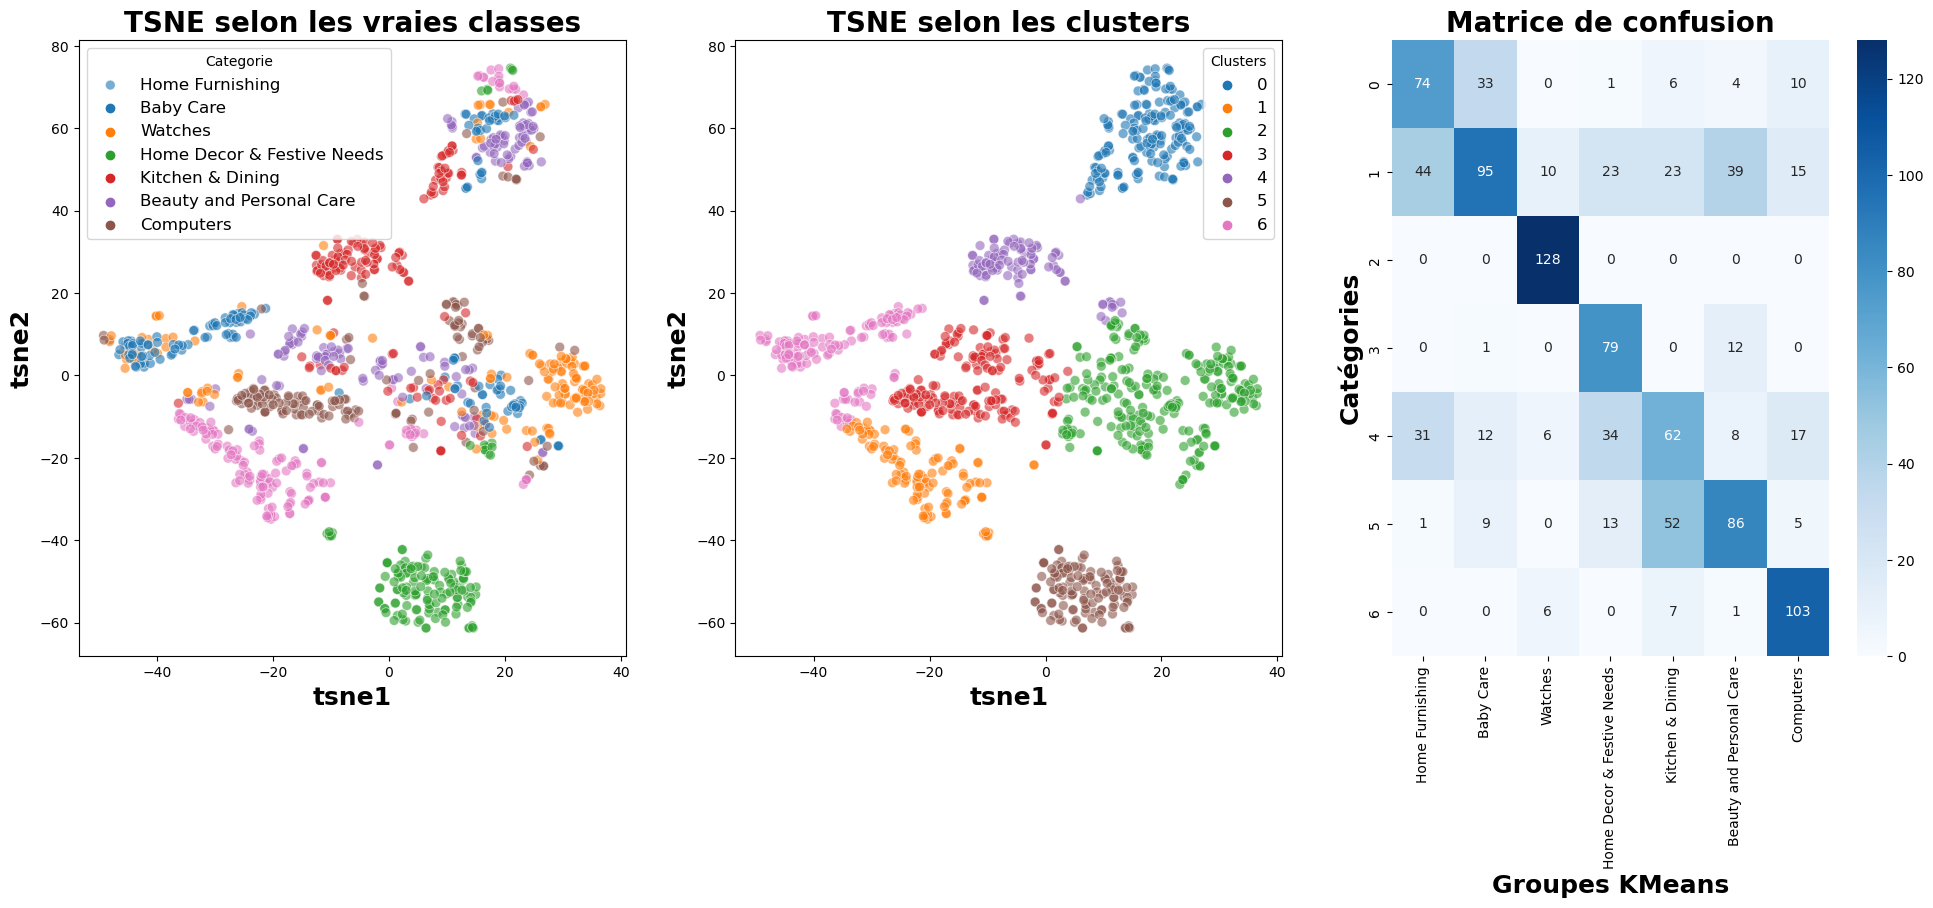

L'indice de Rand ajusté (ARI) pour ce modèle d'extraction de caractéristiques est de 0.324.


In [336]:
# Réduction des dimensions avec PCA
flattened_data_deberta = pd.DataFrame(features_deberta.reshape(1050, 768))
pca_reduced_data_deberta = reduce_dimensionality_pca(flattened_data_deberta, 0.99)

# Appliquer t-SNE pour une visualisation en 2D
tsne_transformed_data_deberta = reduce_dimensionality_tsne(pca_reduced_data_deberta)

# Afficher les graphiques des clusters et calculer le score ARI
plot_tsne_and_kmeans_clusters(tsne_transformed_data_deberta)

## Utilisation de DeBERTa avec un Modèle Plus Grand


Nous allons essayer le modèle deberta-large pour voir si cela améliore les performances 


- **DeBERTa-large :** Une version plus grande de DeBERTa avec environ 340 millions de paramètres. Il dispose de 24 couches de transformateurs, 16 têtes d'attention, et une taille d'embedding de 1024. Ce modèle est plus performant pour des tâches NLP complexes, offrant une meilleure capacité de modélisation des relations sémantiques, mais nécessite davantage de ressources computationnelles et de temps d'entraînement. Il est idéal pour des tâches où la précision est cruciale.

In [337]:
import time
from transformers import AutoTokenizer, TFAutoModel

def extraire_caracteristiques_textuelles_avec_deberta(df, modele_nom='microsoft/deberta-large', taille_lot=10, longueur_max=64):
    """
    Extraire les caractéristiques textuelles en utilisant le modèle DeBERTa.

    Paramètres:
    df (pd.DataFrame): DataFrame contenant une colonne 'DescriptionComplete' avec des données textuelles.
    modele_nom (str): Le modèle DeBERTa à utiliser ('microsoft/deberta-base' ou 'microsoft/deberta-large').
    taille_lot (int): Taille des lots à utiliser pour le traitement.
    longueur_max (int): Longueur maximale des séquences.

    Retourne:
    np.ndarray: Caractéristiques extraites du modèle DeBERTa.
    """
    
    # Extraction des phrases du DataFrame
    phrases = df['DescriptionComplete'].values.tolist()
    
    # Chargement du tokenizer et du modèle DeBERTa
    tokenizer = AutoTokenizer.from_pretrained(modele_nom)
    modele = TFAutoModel.from_pretrained(modele_nom)
    
    # Enregistrement du temps de début
    debut_temps = time.time()

    # Traitement des phrases par lots
    for etape in range(len(phrases) // taille_lot):
        idx_debut_lot = etape * taille_lot
        
        ids_entree = []
        ids_type_token = []
        masques_attention = []

        # Tokenisation des phrases dans le lot
        for phrase in phrases[idx_debut_lot:idx_debut_lot + taille_lot]:
            entree_encodee = tokenizer.encode_plus(
                phrase,
                add_special_tokens=True,
                max_length=longueur_max,
                padding='max_length',
                return_attention_mask=True, 
                return_token_type_ids=True,
                truncation=True,
                return_tensors='tf'
            )

            ids_entree.append(entree_encodee['input_ids'][0])
            ids_type_token.append(entree_encodee['token_type_ids'][0])
            masques_attention.append(entree_encodee['attention_mask'][0])

        ids_entree = np.asarray(ids_entree)
        ids_type_token = np.asarray(ids_type_token)
        masques_attention = np.asarray(masques_attention)
        
        # Création d'un dictionnaire avec les textes prétraités
        texte_pretraite = {
            "input_ids": ids_entree, 
            "attention_mask": masques_attention, 
            "token_type_ids": ids_type_token
        }
        
        # Obtention des sorties du modèle DeBERTa
        sorties_modele = modele(texte_pretraite)
        derniers_etats_caches = sorties_modele[0]
             
        if etape == 0:
            tous_etats_caches = derniers_etats_caches
        else:
            tous_etats_caches = np.concatenate((tous_etats_caches, derniers_etats_caches), axis=0)
    
    # Calcul de la moyenne des derniers états cachés
    caracteristiques_deberta = np.mean(tous_etats_caches, axis=1)
    
    # Enregistrement du temps de fin et calcul du temps écoulé
    fin_temps = np.round(time.time() - debut_temps, 0)
    print("Temps de traitement : ", fin_temps, "secondes")
    
    return caracteristiques_deberta

### Extraction des features

### Ajustement des Hyperparamètres


- Pour ajuster les hyperparamètres tels que la longueur maximale des séquences (max_length) ou la taille des lots (batch_size), nous pouvons simplement modifier les valeurs lors de l'appel à la fonction.

In [338]:
# Extraire les caractéristiques avec DeBERTa avec des hyperparamètres ajustés
features_deberta_ = extraire_caracteristiques_textuelles_avec_deberta(
    df, 
    modele_nom='microsoft/deberta-large', 
    taille_lot=16,  # Augmenter la taille des lots
    longueur_max=128  # Augmenter la longueur maximale des séquences
)

# Afficher la forme des arrays
print(features_deberta_.shape)

All model checkpoint layers were used when initializing TFDebertaModel.

All the layers of TFDebertaModel were initialized from the model checkpoint at microsoft/deberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaModel for predictions without further training.


Temps de traitement :  865.0 secondes
(1040, 1024)


## Réduction de la Dimensionnalité et Visualisation


- Une fois les caractéristiques extraites avec DeBERTa, réutilisons les fonctions existantes pour réduire la dimensionnalité avec PCA et t-SNE, puis visualisons et évaluons les clusters :

In [339]:
def plot_tsne_and_kmeans_clusters_deberta(tsne_data, df):
    """
    Visualise les clusters t-SNE et KMeans et affiche une matrice de confusion pour les résultats DeBERTa.

    Paramètres:
    tsne_data (ndarray): Données transformées par t-SNE.
    df (pd.DataFrame): DataFrame contenant les vraies classes.

    Retourne:
    None
    """
    # Créer un DataFrame à partir des résultats t-SNE
    df_tsne = pd.DataFrame(tsne_data, columns=['tsne1', 'tsne2'])
    df_tsne['class'] = df['Category_Level_1'][:len(tsne_data)]

    # Définir les catégories pour la légende
    categories = df['Category_Level_1_Texte'].unique()
    category_palette = sns.color_palette('tab10', len(categories))

    # Agrandir la figure
    plt.figure(figsize=(24, 8))

    # Afficher les vraies classes
    plt.subplot(131)
    sns.scatterplot(
        x='tsne1', y='tsne2', hue='class', palette=category_palette, s=50, alpha=0.6,
        data=df_tsne, legend='brief'
    )
    plt.title('TSNE selon les vraies classes', fontsize=20, fontweight='bold')
    plt.xlabel('tsne1', fontsize=18, fontweight='bold')
    plt.ylabel('tsne2', fontsize=18, fontweight='bold')
    plt.legend(title='Categorie', labels=categories, prop={'size': 12})

    # Créer des clusters avec KMeans
    kmeans = cluster.KMeans(n_clusters=7, n_init=100)
    kmeans.fit(tsne_data)
    df_tsne['cluster'] = kmeans.labels_

    # Afficher les clusters KMeans
    plt.subplot(132)
    sns.scatterplot(
        x='tsne1', y='tsne2', hue='cluster',
        palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
        data=df_tsne, legend='brief'
    )
    plt.title('TSNE selon les clusters', fontsize=20, fontweight='bold')
    plt.xlabel('tsne1', fontsize=18, fontweight='bold')
    plt.ylabel('tsne2', fontsize=18, fontweight='bold')
    plt.legend(title='Clusters', prop={'size': 12})

    # Créer la matrice de confusion
    try:
        labels = df['Category_Level_1'][:len(kmeans.labels_)]
        conf_mat = metrics.confusion_matrix(labels, kmeans.labels_)
        corresp = np.argmax(conf_mat, axis=0)
        labels_df = pd.Series(labels, name="y_true").to_frame()
        labels_df['y_pred'] = kmeans.labels_
        labels_df['y_pred_transform'] = labels_df['y_pred'].apply(lambda x: corresp[x])

        cls_labels_transform = np.array(labels_df['y_pred_transform'])
        conf_mat2 = metrics.confusion_matrix(labels, cls_labels_transform)
        list_labels = df['Category_Level_1_Texte'].unique()

        df_cm = pd.DataFrame(conf_mat2, index=[label for label in list_labels], columns=[i for i in "0123456"])
        plt.subplot(133)
        plt.title('Matrice de confusion', size=20, fontweight='bold')
        sns.heatmap(df_cm.T, annot=True, cmap="Blues", fmt='d')
        plt.xlabel('Groupes KMeans', fontsize=18, fontweight='bold')
        plt.ylabel('Catégories', fontsize=18, fontweight='bold')
        plt.show()

    except ValueError as e:
        print("Erreur :", e)

    # Afficher l'ARI (Adjusted Rand Index)
    ari = round(metrics.adjusted_rand_score(labels, kmeans.labels_), 3)
    print("L'indice de Rand ajusté (ARI) pour ce modèle d'extraction de caractéristiques est de {}.".format(ari))

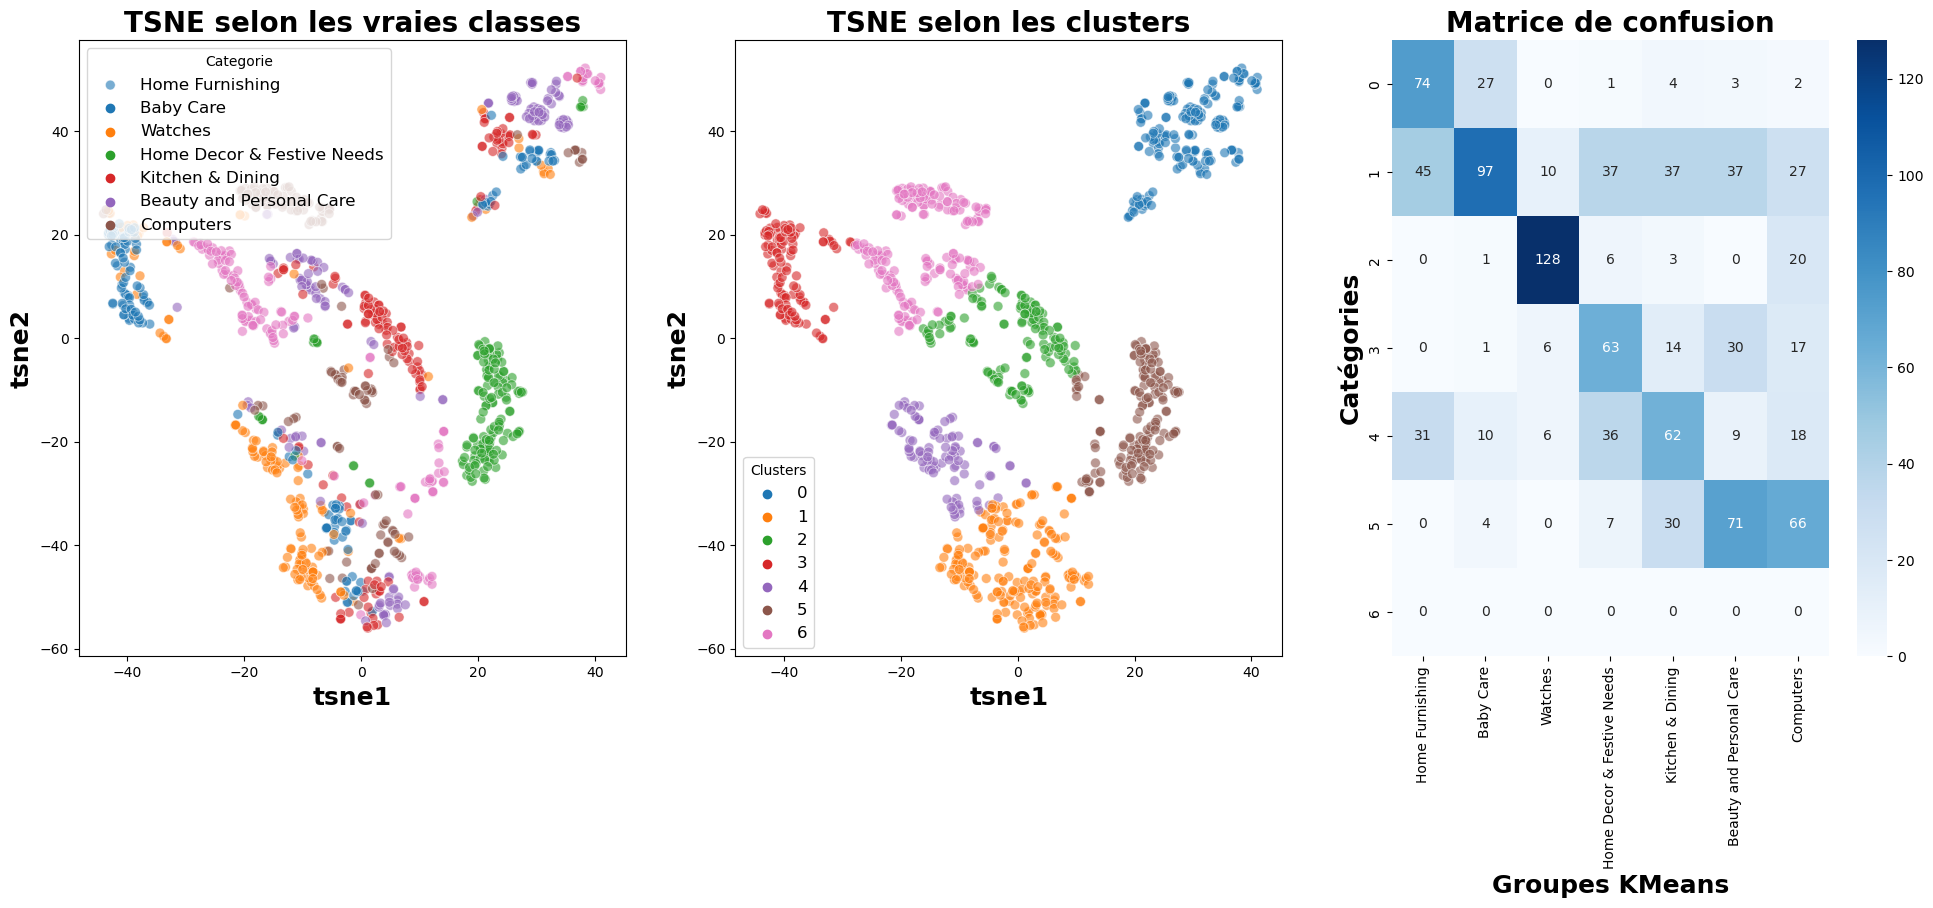

L'indice de Rand ajusté (ARI) pour ce modèle d'extraction de caractéristiques est de 0.23.


In [340]:
# Réduction des dimensions avec PCA
flattened_data_deberta = pd.DataFrame(features_deberta_.reshape(features_deberta_.shape[0], -1))
pca_reduced_data_deberta = reduce_dimensionality_pca(flattened_data_deberta, 0.99)

# Appliquer t-SNE pour une visualisation en 2D
tsne_transformed_data_deberta = reduce_dimensionality_tsne(pca_reduced_data_deberta)

# Exécuter la fonction avec DeBERTa
plot_tsne_and_kmeans_clusters_deberta(tsne_transformed_data_deberta, df)

### Explication avec SHAP (global et local) et Explication avec LIME (local)

Accuracy of the model: 0.9333333333333333


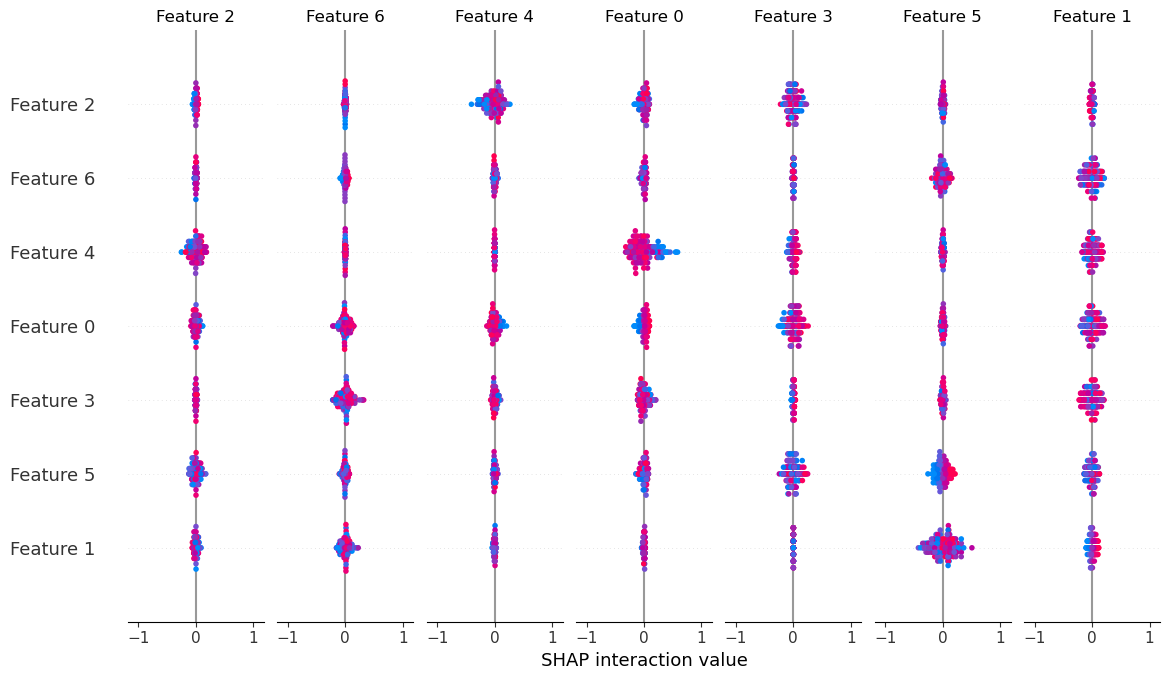

In [342]:
import shap
import lime
import lime.lime_tabular
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Étape 1 : Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features_deberta, df['Category_Level_1_Texte'], test_size=0.2, random_state=42)

# Étape 2 : Entraîner un modèle de régression logistique
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Étape 3 : Prédictions et évaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the model: {accuracy}")

# ---- SHAP ----
# Étape 4 : Explication globale avec SHAP
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)

# Graphique SHAP Summary (importance globale des caractéristiques)
shap.summary_plot(shap_values, X_test)

# Étape 5 : Explication locale avec SHAP (pour un exemple spécifique)

# Convertir les valeurs SHAP en float64 pour éviter les erreurs de JSON
shap_values_for_output = shap_values[..., output_index].astype(np.float64)  # Conversion en float64
X_test_float64 = X_test.astype(np.float64)

# Affichage de l'explication locale avec shap.plots.force après la conversion
shap.plots.force(base_value, shap_values_for_output[0], X_test_float64[0])

### 1. **Graphique SHAP Summary Plot (Importance globale des caractéristiques)** :
Ce graphique montre l'importance globale des interactions entre les caractéristiques dans les prédictions du modèle.

- **Explication générale** : Les points représentent des valeurs SHAP pour chaque caractéristique, et chaque colonne représente une caractéristique. Les points roses indiquent les valeurs élevées de la caractéristique, tandis que les points bleus montrent les valeurs faibles.
- **Interprétation** :
  - Les caractéristiques comme **Feature 6**, **Feature 4**, et **Feature 0** ont une forte influence sur les prédictions, car les points sont bien dispersés sur l'axe horizontal, indiquant qu’elles contribuent fortement aux prédictions du modèle.
  - **Valeurs proches de 0** : Les points proches de 0 sur l'axe horizontal signifient que la caractéristique n’a pas beaucoup d’influence sur les prédictions pour certaines instances.

### 2. **Graphique SHAP Force Plot (Explication locale)** :
Ce graphique montre comment chaque caractéristique influence une prédiction spécifique.

- **Interprétation** :
  - La valeur de base (base value) est située à **0.917**.
  - Les flèches roses indiquent les caractéristiques qui augmentent la prédiction vers des valeurs plus élevées (valeurs positives), et les flèches bleues montrent celles qui poussent la prédiction vers des valeurs plus basses.
  - **Interprétation du modèle** : Dans cet exemple spécifique, le modèle est fortement influencé par certaines caractéristiques qui réduisent la prédiction (flèches bleues), et d’autres qui l’augmentent (flèches rouges), ce qui donne une prédiction ajustée.

In [343]:
# ---- LIME ----
# Étape 6 : Explication locale avec LIME
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train, 
    feature_names=[f'feature_{i}' for i in range(X_train.shape[1])], 
    class_names=df['Category_Level_1_Texte'].unique(),
    verbose=True, 
    mode='classification'
)

# Explication LIME pour un exemple spécifique
lime_instance = lime_explainer.explain_instance(X_test[0], model.predict_proba)
lime_instance.show_in_notebook(show_table=True)

# Si vous ne travaillez pas dans un notebook, vous pouvez enregistrer l'explication dans un fichier HTML
# lime_instance.save_to_file('lime_explanation.html')

Intercept 0.2571291540774877
Prediction_local [0.3160116]
Right: 0.07759109981695678


### 3. **Graphique LIME (Explication locale des probabilités)** :
Ce graphique montre comment **LIME** décompose une prédiction locale en termes de probabilités de classe et caractéristiques influentes.

- **Prédiction locale** : La classe prédite est "Watches" avec une probabilité de **0.78**. Cela signifie que le modèle est confiant que cet exemple appartient à la catégorie "Watches".
- **Interprétation des caractéristiques** :
  - Les caractéristiques listées à droite, telles que **Feature_726**, **Feature_569**, et **Feature_43**, sont les plus influentes dans la prédiction. Par exemple, **Feature_726** a une valeur de **18.42** et contribue à prédire que cet exemple n'appartient pas à la classe "Baby Care".
  - À gauche, les barres indiquent les décisions du modèle pour exclure certaines classes et privilégier d'autres. Par exemple, les caractéristiques sur le côté "NOT Baby Care" influencent le modèle pour exclure cette catégorie.

### En résumé :
- Le **SHAP Summary Plot** vous donne une vue d'ensemble des caractéristiques les plus influentes dans les prédictions du modèle.
- Le **SHAP Force Plot** montre comment les caractéristiques individuelles affectent une prédiction spécifique.
- Le **graphique LIME** vous aide à comprendre localement pourquoi le modèle a choisi une certaine classe pour un exemple donné, en décomposant les probabilités de prédiction.